# Covid-19 Analysis In South Korea

## Data preparation

Data was downloaded from [Kaggle](https://www.kaggle.com/datasets/kimjihoo/coronavirusdataset) website and saved in local folder. For our data analysis we need to set up the environment. By doing it we first need to import all necessary libraries to the notebook and provide special function - `%matplotlib inline`. With this back end, the output of plotting commands is displayed inline within front ends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

Importing libraries to the notebook.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import random
import scipy.cluster.hierarchy as sch

from datetime import timedelta

Set up styles for plotting.

In [2]:
# Warm palette
custom_palette = sns.color_palette("Blues_r")
sns.set_palette(custom_palette)

# Activating white grid
sns.set(style="whitegrid")

# Default figure size for all Seaborn plots
sns.set(rc={'figure.figsize': (10, 6)})

# Set up colors for pie plot
colors = sns.color_palette("Set2")

Shape file of countries in the world downloaded from [NaturalEarthData](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/).

In [3]:
# Add South Korea boundary
south_korea_shp_path = "border/ne_10m_admin_0_countries_kor.shp"

Now we can import the data to the notebook, read it from `.csv` and convert it to the data frame. Base by dataset provider we already know that data contains of 11 different `.csv` files. Let's provide the path to the data which we will be using and load it to the data frame.

In [4]:
# Providing path
data_path = "data/"

# Importing datasets
df_case = pd.read_csv(f"{data_path}/Case.csv")
df_patientinfo = pd.read_csv(f"{data_path}/PatientInfo.csv")
df_policy = pd.read_csv(f"{data_path}/Policy.csv")
df_region = pd.read_csv(f"{data_path}/Region.csv")
df_time = pd.read_csv(f"{data_path}/Time.csv")
df_timeage = pd.read_csv(f"{data_path}/TimeAge.csv")
df_timegender = pd.read_csv(f"{data_path}/TimeGender.csv")
df_timeprovince = pd.read_csv(f"{data_path}/TimeProvince.csv")

Brief look to our data:
<ol>
    <li>Case.csv - Data of COVID-19 infection cases</li>
    <li>PatientInfo.csv - Epidemiological data of COVID-19 patients</li>
    <li>Policy.csv - Data of the government policy for COVID-19</li>
    <li>Region.csv - Location and statistical data of the cities, regions and all South Korea</li>
    <li>SearchTrend.csv - Trend data of the keywords searched in NAVER which is one of the largest portals</li>
    <li>SeoulFloating.csv - Data of floating population in Seoul</li>
    <li>Time.csv - Time series data of COVID-19 status</li>
    <li>TimeAge.csv - Time series data of COVID-19 status in terms of the age</li>
    <li>TimeGender.csv - Time series data of COVID-19 status in terms of gender</li>
    <li>TimeProvince.csv - Time series data of COVID-19 status in terms of the Province</li>
    <li>Weather.csv - Data of the weather in the regions</li>
</ol>

# Data cleaning

Before working with data we need to prepare it by making some adjustments, like fixing dtypes, cleaning for duplicates, etc.

## PatientInfo

In [5]:
# Check data types and missing values
df_patientinfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [6]:
# Convert features of data set
df_patientinfo.iloc[:, -5:-1] = df_patientinfo.iloc[:, -5:-1].apply(pd.to_datetime, 
                                                                    errors='coerce')

# Convert data type 
df_patientinfo["contact_number"] = df_patientinfo["contact_number"].apply(pd.to_numeric, 
                                                                          errors='coerce')

We can see that our data consists of a lot of **NaN** values, this will limit out analysis, but they do not affect each other features, if we need to fix them we'll do it as we go along. Also, we see some strange deviation in contact_number, we need to change some values inside, because base by logic there should not be **negative contacts** and also one person cannot infect **more than ten thousand** or even a million people. Data can be corrupted while it was prepared. We're going to fix it by **removing these rows**.

In [7]:
# Remove misleading values less than 0 and more than 10_000 from data set
df_patientinfo = df_patientinfo.loc[~(
    (df_patientinfo["contact_number"] < 0) |
    (df_patientinfo["contact_number"] > 10_000))]

## Case

In [8]:
df_case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0    case_id        174 non-null    int64 
 1   province        174 non-null    object
 2   city            174 non-null    object
 3   group           174 non-null    bool  
 4   infection_case  174 non-null    object
 5   confirmed       174 non-null    int64 
 6   latitude        174 non-null    object
 7   longitude       174 non-null    object
dtypes: bool(1), int64(2), object(5)
memory usage: 9.8+ KB


Latitude and longitude should be numeric values, we can change it by converting these features.

In [9]:
# Change dtypes of latitude and longitude
df_case.iloc[:, -2:] = df_case.iloc[:, -2:].apply(pd.to_numeric,
                                                  errors='coerce')

df_case.describe()

,case_id,confirmed,latitude,longitude
count,1.740000e+02,174.000000,65.000000,65.000000
mean,2.686216e+06,65.488506,36.694051,127.584885
std,1.943218e+06,355.097654,0.911466,0.823087
min,1.000001e+06,0.000000,35.078825,126.316746
25%,1.100006e+06,4.000000,35.848190,126.956405
50%,1.700004e+06,10.000000,37.000354,127.113900
75%,4.100004e+06,31.750000,37.522331,128.466653
max,7.000004e+06,4511.000000,37.758635,129.125600


As we know only 4 features consists of numeric value. First one **case_id**, we know this feature is unique for every case, so it will not give us any important information. Second thing is **confirmed**, these values have quite big standard deviation and maximum value, we know that some cases can have only few or zero confirmed cases while other can have thousands, we assume these high numbers as an outliers, but we will use them as legit values without modifying them. And lastly **latitude, longitude** these values will help us to plot spatial data.

## TimeAge

In [10]:
df_timeage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1089 non-null   object
 1   time       1089 non-null   int64 
 2   age        1089 non-null   object
 3   confirmed  1089 non-null   int64 
 4   deceased   1089 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.7+ KB


We can **change data type of date** and also **remove unnecessary time column**.

In [11]:
df_timeage = df_timeage.drop(columns=["time"])

df_timeage["date"] = df_timeage["date"].apply(pd.to_datetime, errors='coerce')
df_timeage["date"] = df_timeage["date"].dt.date

## TimeGender

In [12]:
df_timegender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       242 non-null    object
 1   time       242 non-null    int64 
 2   sex        242 non-null    object
 3   confirmed  242 non-null    int64 
 4   deceased   242 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 9.6+ KB


We can **change data type of date** and also **remove unnecessary time column**.

In [13]:
# Drop column time
df_timegender.drop(columns=["time"], inplace=True)

# Change datatype of date
df_timegender["date"] = df_timegender["date"].apply(pd.to_datetime,
                                                    errors='coerce')
df_timegender["date"] = df_timegender["date"].dt.date

## Time

In [14]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       163 non-null    object
 1   time       163 non-null    int64 
 2   test       163 non-null    int64 
 3   negative   163 non-null    int64 
 4   confirmed  163 non-null    int64 
 5   released   163 non-null    int64 
 6   deceased   163 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 9.0+ KB


We can **change data type of date**.

In [15]:
# Change datatype of date
df_time["date"] = df_time["date"].apply(pd.to_datetime, 
                                        errors='coerce')
df_time["date"] = df_time["date"].dt.date

# Remove time feature
df_time.drop(columns=["time"], inplace=True)

## Policy

In [16]:
df_policy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   policy_id   61 non-null     int64 
 1   country     61 non-null     object
 2   type        61 non-null     object
 3   gov_policy  61 non-null     object
 4   detail      59 non-null     object
 5   start_date  61 non-null     object
 6   end_date    24 non-null     object
dtypes: int64(1), object(6)
memory usage: 3.5+ KB


We can drop some unnecessary columns and modify **start_date** data type.

In [17]:
# Drop columns which will not be used
df_policy.drop(columns=["policy_id", "country", "end_date"], inplace=True)

# Change datatypes of data
df_policy["start_date"] = df_policy["start_date"].apply(pd.to_datetime,
                                                        errors='coerce')

## Region

In [18]:
df_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   code                      244 non-null    int64  
 1   province                  244 non-null    object 
 2   city                      244 non-null    object 
 3   latitude                  244 non-null    float64
 4   longitude                 244 non-null    float64
 5   elementary_school_count   244 non-null    int64  
 6   kindergarten_count        244 non-null    int64  
 7   university_count          244 non-null    int64  
 8   academy_ratio             244 non-null    float64
 9   elderly_population_ratio  244 non-null    float64
 10  elderly_alone_ratio       244 non-null    float64
 11  nursing_home_count        244 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 23.0+ KB


In [19]:
df_region.describe()

,code,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,32912.090164,36.396996,127.661401,74.180328,107.901639,4.151639,1.294754,20.923730,10.644672,1159.258197
std,19373.349736,1.060304,0.904781,402.713482,588.788320,22.513041,0.592898,8.087428,5.604886,6384.185085
min,10000.000000,33.488936,126.263554,4.000000,4.000000,0.000000,0.190000,7.690000,3.300000,11.000000
25%,14027.500000,35.405263,126.927663,14.750000,16.000000,0.000000,0.870000,14.117500,6.100000,111.000000
50%,30075.000000,36.386601,127.384249,22.000000,31.000000,1.000000,1.270000,18.530000,8.750000,300.000000
75%,51062.500000,37.466119,128.473953,36.250000,55.250000,3.000000,1.612500,27.262500,14.625000,694.500000
max,80000.000000,38.380571,130.905883,6087.000000,8837.000000,340.000000,4.180000,40.260000,24.700000,94865.000000


In [20]:
# Remove Korea row as we don't need overall data
df_region = df_region.drop(df_region[df_region["city"] == "Korea"].index)

In [21]:
# Rename some columns
df_region = df_region.rename(columns={"elderly_population_ratio": "Elderly Population Ratio", 
                                      "elderly_alone_ratio": "Elderly Alone Ratio"})

# Exploratory data analysis

The world is still struggling with one of the most rapidly spreading pandemics. There are a lot of people who say that data is the best weapon we can use in this "Corona Fight." **We will explore "South Korea" dataset and make the summary to find critical insights about the pandemic**.

## EDA PatientInfo

<ul>
    <li><b>Who is the first person to get Covid-19?</b></li>
    <li><b>How people get infected?</b></li>
    <li><b>Which genders and age groups tend to get virus more often?</b></li>
</ul>

In [22]:
print(f"Number of patients: {df_patientinfo['patient_id'].count()}")
print(f"Number of unique cases: {len(df_patientinfo['infection_case'].unique())}")

df_patientinfo.sort_values(by=["symptom_onset_date"], ascending=True).head(5)

Number of patients: 5162
Number of unique cases: 52


,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1644,1400000001,female,30s,China,Incheon,etc,overseas inflow,NaN,NaN,2020-01-19,2020-01-20,2020-02-06,NaT,released
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaT,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaT,released
1600,1300000001,female,40s,Korea,Gwangju,NaN,overseas inflow,NaN,450.0,2020-01-27,2020-02-03,2020-02-20,NaT,released
1646,1400000003,male,50s,Korea,Incheon,Michuhol-gu,etc,NaN,NaN,2020-01-31,2020-02-25,2020-03-03,NaT,released


We can see that first person was **women in here 30s** from China. She got confirmed in **2020-01-20** from overseas inflow. While the first individual from **Korea is man in his 50s** who get confirmed of infection in **2020-01-23** by also overseas inflow. As we know we have a lot of missing values in this dataset, which will limit out analysis, still let's proceed further and check top 5 most infection cases.

In [23]:
# Group by infection cases
patient_infection_cases = df_patientinfo.groupby(
    by=["infection_case"], as_index=False)["contact_number"].sum()

# Top 5 cases
patient_top5_cases = patient_infection_cases.sort_values(
    by="contact_number", ascending=False).head(5)

In [24]:
# Top 5 infection cases
patient_top5_cases

,infection_case,contact_number
46,contact with patient,3680.0
47,etc,2559.0
38,Shincheonji Church,2360.0
50,overseas inflow,2119.0
26,Onchun Church,1422.0


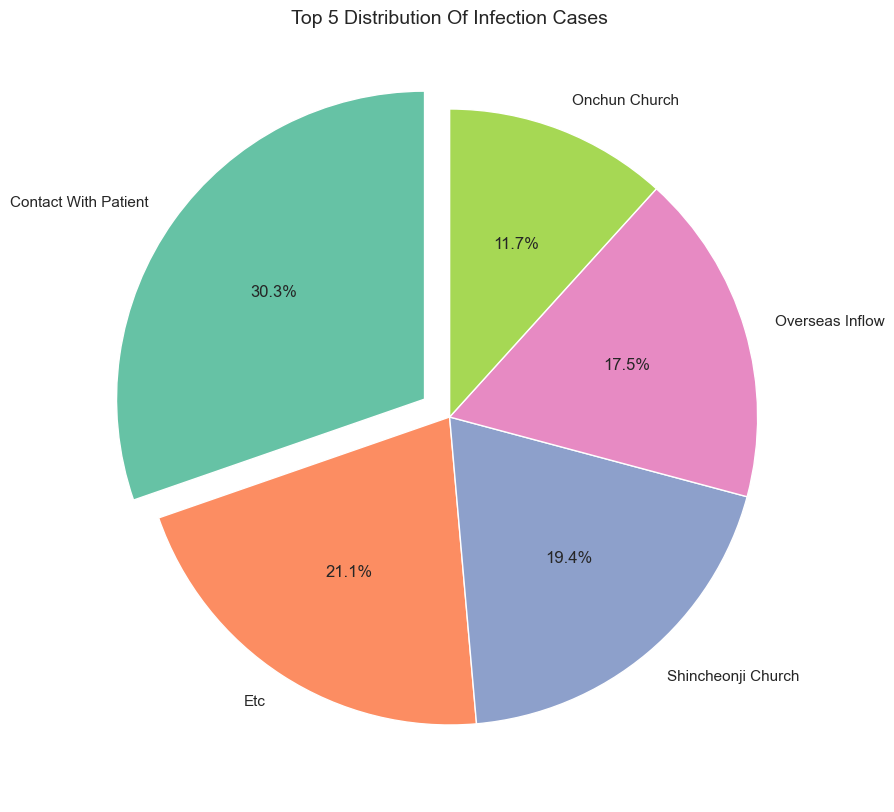

In [25]:
# Set figure size
plt.figure(figsize=(10, 10))

# Set up labels for pie chart
pie_labels =  [x.title() for x in patient_top5_cases["infection_case"]]

# Pie plot distribution
plt.pie(patient_top5_cases["contact_number"],
        labels=pie_labels,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.1, 0, 0, 0, 0],
        colors=colors)

# Set title
plt.title("Top 5 Distribution Of Infection Cases", fontsize=14);

We see that most of the infections come from **Contact With Patient** it takes **3680 contacts - 30.3%** of top cases, as we know **Covid - 19** spreads through contacting with other persons, as the distribution show, other top infections are in gathering place like **Church** combining them both we can see that it is taking **3782 contacts- 31.1%** as people tend to sit next to each other in churches. **Etc** cases which is not define take **2559 contacts - 21.2%**, also **Overseas Inflow** take big piece in out chart **2119 contacts - 17.5%**, assuming a lot of people get infected traveling through countries. Let's see distribution how much contacts one person have, **from statistical view contact_number**  show that most of the contacts goes lower than **50 contacts per people** will put threshold as 50 people, it's very low chance that one person can contact more than 50 people. All values higher than 50 can be assumed as an outlier.

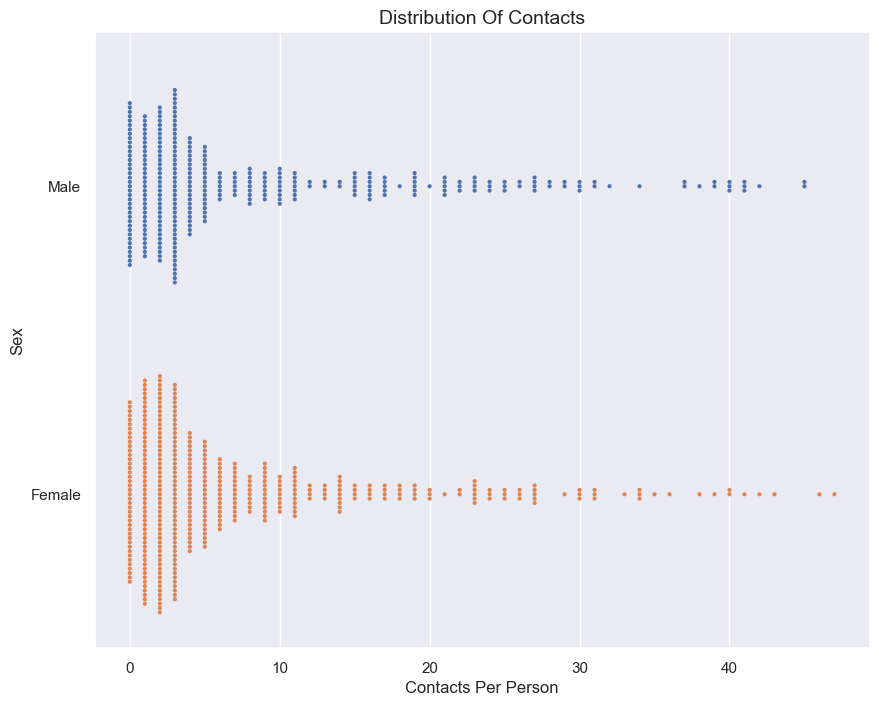

In [26]:
# Set threshold
contact_threshold = 50

# Set figure size
plt.figure(figsize=(10, 8))

# Plot swarm plot
sns.swarmplot(data=df_patientinfo,
              x=df_patientinfo["contact_number"].where(
                  df_patientinfo["contact_number"] < contact_threshold),
              y=df_patientinfo["sex"],
              size=3)

# Set title and labels
plt.title("Distribution Of Contacts", fontsize=14)
plt.xlabel("Contacts Per Person")
plt.yticks([0, 1], ["Male", "Female"])
plt.ylabel("Sex");

As reflected **the highest number of contacts goes from 0 to 3, from there we see contacts decreasing**. At about **8 contacts both male and female have similar numbers**. Men tend to contact less than women, there are cases there people contacted for than 10 people, we can assume they can be working a contact job or possible they are still going to schools or university. Now we can demonstrate the contact number distribution over age and sex.

In [27]:
# Group over sex and age
df_patientinfo_sex_age_group = df_patientinfo.groupby(
    by=["sex", "age"], as_index=False)["contact_number"].sum()

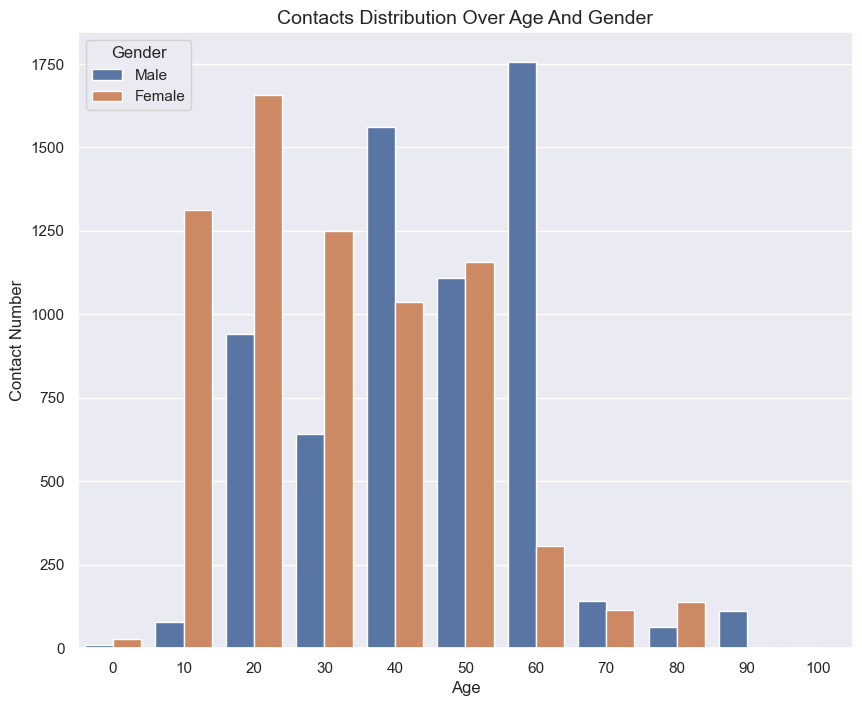

In [28]:
# Set figure size
plt.figure(figsize=(10, 8))

# Filtered age
ages = [int(x.strip("s")) for x in df_patientinfo_sex_age_group["age"]]

# Plot bar plot
ax = sns.barplot(
    data=df_patientinfo_sex_age_group,
    x=ages,
    y="contact_number",
    hue="sex")

# Set title and labels
plt.title("Contacts Distribution Over Age And Gender", fontsize=14)
plt.xlabel("Age")
plt.ylabel("Contact Number")

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["Male", "Female"], title="Gender");

In [29]:
df_patientinfo_sex_age_group.sort_values(by=["contact_number"],
                                         ascending=False,
                                         inplace=True)

df_head_and_tail = pd.concat([
    df_patientinfo_sex_age_group.head(5),
    df_patientinfo_sex_age_group.tail(5)
])
df_head_and_tail

,sex,age,contact_number
7,female,60s,1757.0
13,male,20s,1657.0
5,female,40s,1562.0
12,male,10s,1314.0
14,male,30s,1250.0
9,female,80s,65.0
11,male,0s,29.0
0,female,0s,9.0
1,female,100s,0.0
20,male,90s,0.0


**Female tend to have more contact from start of 10s to end of 30s while men highs goes from start of 40s to end of 60s which show significant high contact number, only in the 50s both genres have almost the same contact numbers. We also see female childs have more contacts over men while in the 90s huge opposite situation we have only male contacts, and for 100s we see no contacts for both genre, while individuals still got infected**.

## EDA Case

<ul>
    <li><b>Do people tend to get infected in groups or one by one?</b></li>
</ul>

In [30]:
df_case.describe()

,case_id,confirmed,latitude,longitude
count,1.740000e+02,174.000000,65.000000,65.000000
mean,2.686216e+06,65.488506,36.694051,127.584885
std,1.943218e+06,355.097654,0.911466,0.823087
min,1.000001e+06,0.000000,35.078825,126.316746
25%,1.100006e+06,4.000000,35.848190,126.956405
50%,1.700004e+06,10.000000,37.000354,127.113900
75%,4.100004e+06,31.750000,37.522331,128.466653
max,7.000004e+06,4511.000000,37.758635,129.125600


In [31]:
df_case.sample(5)

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
47,1100010,Busan,-,False,etc,30,NaN,NaN
54,1200007,Daegu,from other city,True,Cheongdo Daenam Hospital,2,NaN,NaN
41,1100004,Busan,Haeundae-gu,True,Haeundae-gu Catholic Church,6,35.205990,129.125600
140,5100001,Jeollanam-do,Muan-gun,True,Manmin Central Church,2,35.078825,126.316746
64,1400002,Incheon,from other city,True,Coupang Logistics Center,42,NaN,NaN


In [32]:
print(f"Number of cases: {df_case.shape[0]}")
print(f"Number of unique cases: {len(df_case['infection_case'].unique())}")

Number of cases: 174
Number of unique cases: 81


From sample data we see that we have **bool** feature which will say if case is group or not, this will help us to group our data.

In [33]:
# Group cases to group and individual
df_case_grouped = df_case.groupby(by=["group"],
                                  as_index=False)["confirmed"].sum()

df_case_grouped.sort_values(by=["confirmed"], ascending=False)

,group,confirmed
1,True,7851
0,False,3544


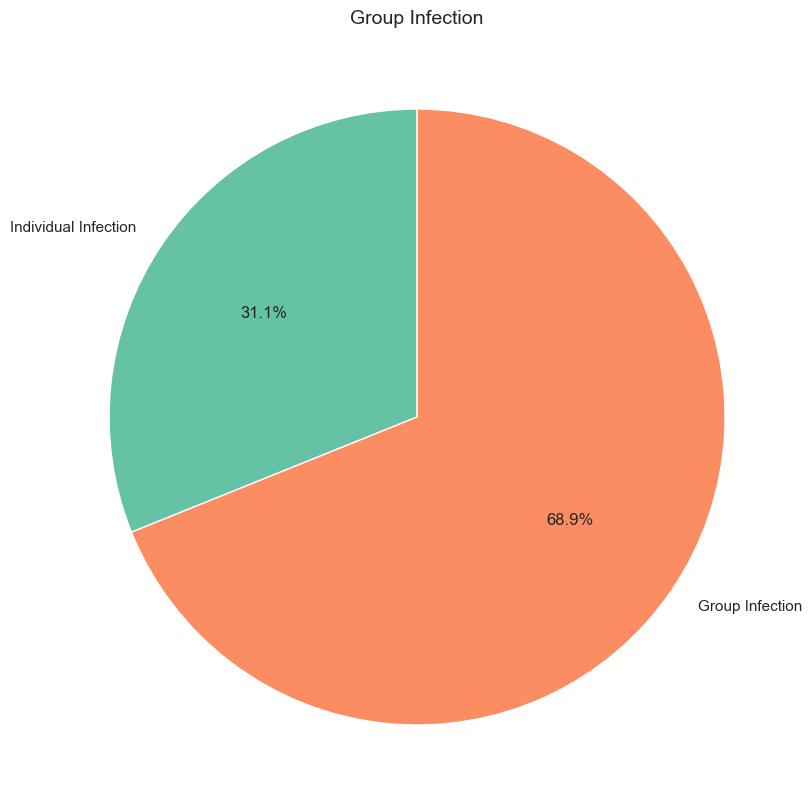

In [34]:
# Set figure size
plt.figure(figsize=(10, 10))

# Pie plot distribution
plt.pie(df_case_grouped["confirmed"],
        labels=["Individual Infection", "Group Infection"],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors)

# Set pie title
plt.title("Group Infection", fontsize=14);

As shown **7851 contacts was group infection which is 68.9% of our data while 3544 individual infection from one person - 31.1%**, more than double of cases appear because people tend to attend in group activities, visit church, gym, clubs etc.

## EDA TimeAge

<ul>
    <li><b>How the virus distributes over different age groups?</b></li>
</ul>

In [35]:
df_timeage.describe()

,confirmed,deceased
count,1089.000000,1089.000000
mean,1158.129477,23.419651
std,822.619497,37.387911
min,32.000000,0.000000
25%,530.000000,0.000000
50%,1052.000000,3.000000
75%,1537.000000,35.000000
max,3362.000000,139.000000


In [36]:
df_timeage.sample(5)

,date,age,confirmed,deceased
1056,2020-06-27,30s,1473,2
479,2020-04-24,20s,2934,0
1004,2020-06-21,50s,2230,15
813,2020-05-31,30s,1292,2
188,2020-03-22,80s,392,41


In [37]:
confirmed_count = df_timeage["confirmed"].sum()
deceased_count = df_timeage["deceased"].sum()

# Set up time age variables
min_age_date = df_timeage['date'].min()
max_age_date = df_timeage['date'].max()

print(f"Number of days: {df_timeage['date'].drop_duplicates().count()}")
print(f"Date period: {min_age_date} - {max_age_date}")
print(f"Total number of confirmed cases: {confirmed_count}")
print(f"Total number of deceased cases: {deceased_count}")

Number of days: 121
Date period: 2020-03-02 - 2020-06-30
Total number of confirmed cases: 1261203
Total number of deceased cases: 25504


As described we have groups of ages and related features to it, we can check how these features changes over time.

In [38]:
def line_plot(dataframe, x, y, hue=None):
    """
    :param dataframe: Takes dataframe
    :param x: x label
    :param y: y label
    :param hue: hue 
    :return: Configurated line plot 
    """
    # Set figure size
    plt.figure(figsize=(12, 8))

    # Plot line plot
    sns.lineplot(data=dataframe, x=x, y=y, hue=hue, linewidth=3)

    # Set up title, labels and legend
    plt.xlabel("Date")
    plt.ylabel("Number of Cases")
    plt.tick_params(axis="x", rotation=90)

    if hue == "sex":
        plt.title(f"{y.title()} Cases Distribution Over Gender", fontsize=14)
        plt.legend(title="Gender", labels=["Male", "Female"])
        plt.xlim(min_gender_date - timedelta(days=1),
                 max_gender_date + timedelta(days=1))

    elif hue == "age":
        plt.title(f"{y.title()} Cases Distribution Over Age", fontsize=14)
        plt.legend(title="Age")
        plt.xlim(min_age_date - timedelta(days=1),
                 max_age_date + timedelta(days=1))

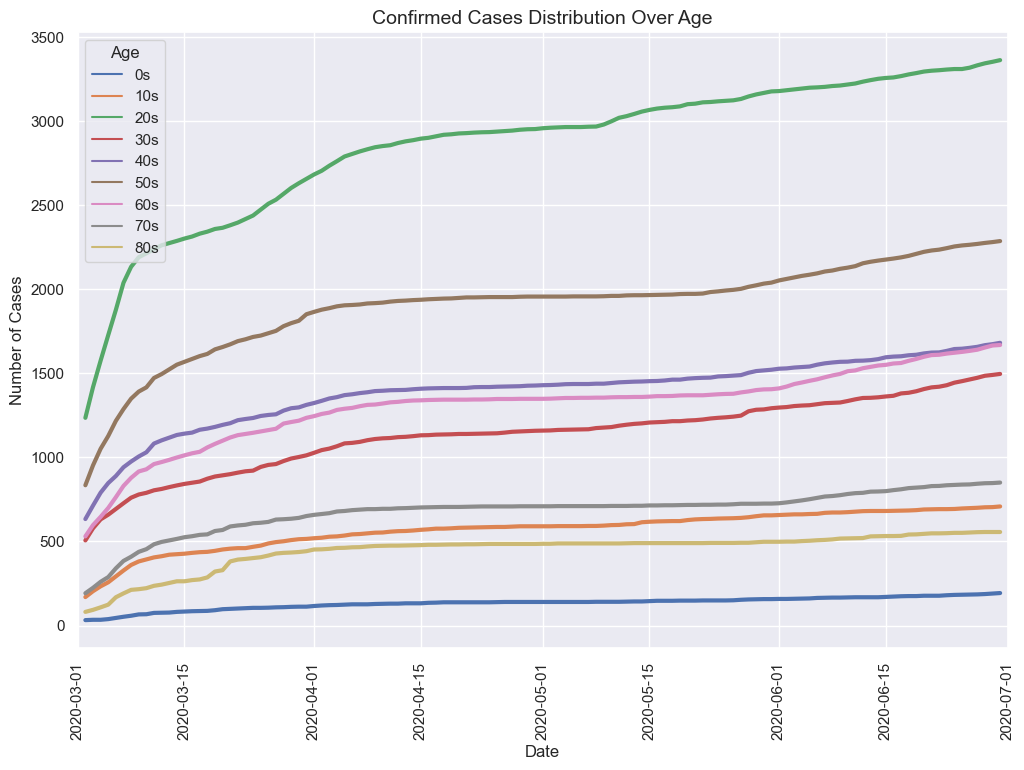

In [39]:
# Plot confirmed cases over time based by age
line_plot(dataframe=df_timeage, x="date", y="confirmed", hue="age")

# Get number of cases
df_timeage_confirmed = df_timeage.groupby(by=["age"],
                                          as_index=False)["confirmed"].sum()

# Create new column and calculate proportion, also converting it to string for easy displaying
df_timeage_confirmed["proportion"] = (df_timeage_confirmed["confirmed"] /
                                      confirmed_count *
                                      100).round(2).astype(str)

# Rotating dataframe and removing column indexes
df_timeage_confirmed = df_timeage_confirmed.transpose()
df_timeage_confirmed.style.hide(axis="columns");

As you see our data goes **from 2020-03-01 until 2020-07-01**, biggest confirmed cases start exploding from **2023-03-01 until 2020-03-08** then it start to go up smooth. At about **2020-03-18 80s get higher** and at **2020-03-29 50s also increase slightly**. At **2023-05-08 20s** start to get more confirmed cases and at about **2023-05-28** all age groups except **0s** also get steeper. We see that all people have similar chance to get Covid-19, mostly the youngest people who tend to be more active, who studying, working and spending more time socializing have more cases than older people.
<ul>
    <li>20s takes 27% of all cases</li>
    <li>0s takes about 1%</li>
    <li>80s takes 4%</li>
</ul>

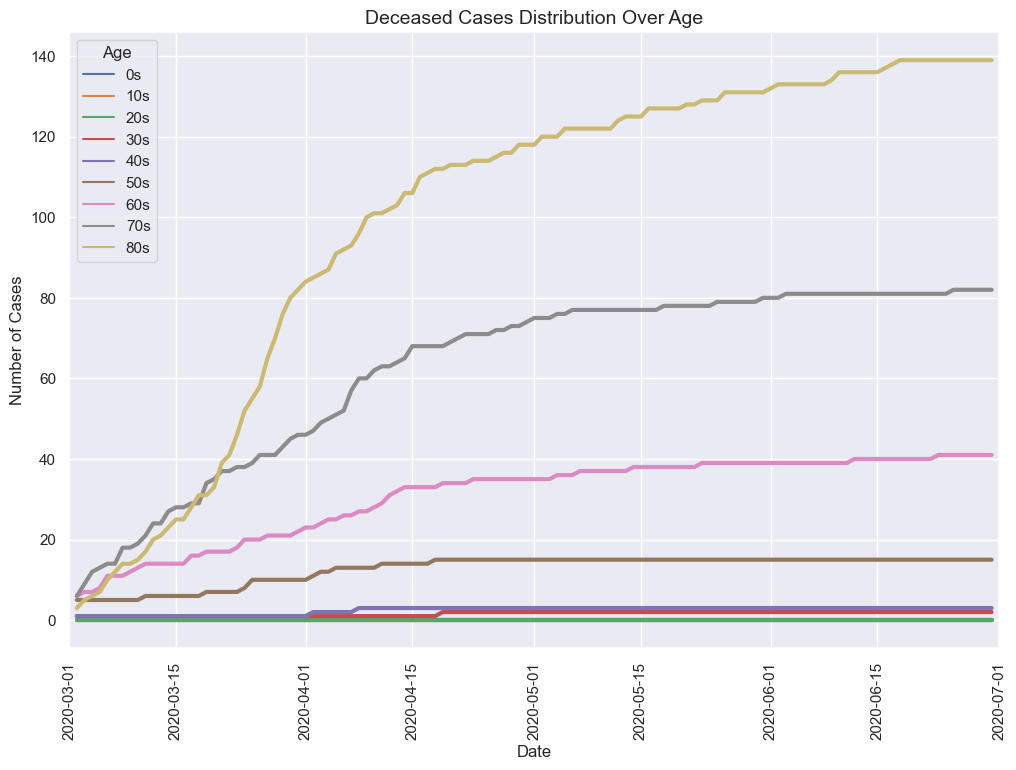

In [40]:
# Plot deceased cases over time based by age
line_plot(dataframe=df_timeage, x="date", y="deceased", hue="age")

# Get number of cases
df_timeage_deceased = df_timeage.groupby(by=["age"],
                                         as_index=False)["deceased"].sum()

# Create new column and calculate proportion, also converting it to string for easy displaying
df_timeage_deceased["proportion"] = (df_timeage_deceased["deceased"] /
                                     deceased_count * 100).round(2).astype(str)

# Rotating dataframe and removing column indexes
df_timeage_deceased = df_timeage_deceased.transpose()
df_timeage_deceased.style.hide(axis="columns");

From this plot we see that **deceased grow mostly for older people** it start from **2020-03-01 and increase rapidly till 2020-03-28 for 80s people** but mostly for all people who are older than **60s it goes till about 2040-04-15**, than line starts to get smoother and stops climbing so much. For younger people who are from **30s to 60s most cases appear from 2020-04-01 till 2020-04-17** than line stops growing. For youngest people from **0s to 30s there are no cases at all**. People older than 50 years old have more chance to get deceased from Covid - 19.
<ul>
    <li>0s, 10s and 20s takes 0% of all cases</li>
    <li>30s, 40s and 50s takes less than 10%</li>
    <li>60s and 70s takes about 45%</li>
    <li>80s takes almost 48%</li>
</ul>

In [41]:
# Add new feature for deceased over confirmed ratio
df_timeage["Deceased Over Confirmed"] = df_timeage["deceased"] / df_timeage["confirmed"]

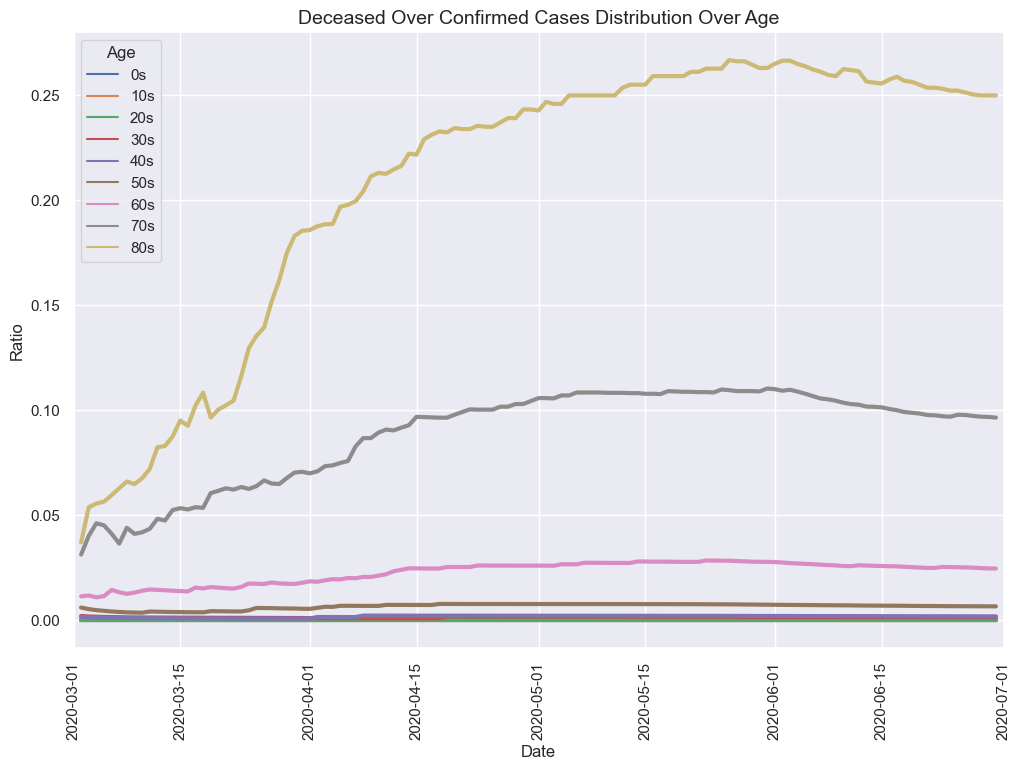

In [42]:
# Plot deceased and confirmed cases ratio over time based by age
line_plot(dataframe=df_timeage, x="date", y="Deceased Over Confirmed", hue="age")
plt.ylabel("Ratio");

As evidenced of danger for older people we see that **deceased over confirmed case ratio is way bigger to older than younger. We can assume that people older than 50 should avoid contacting with others, wash hands more often, cover faces with mask, they have bigger ratio to get sick and deceased**. 

## EDA TimeGender

<ul>
    <li><b>How the virus distributes over different genders?</b></li>
</ul>

In [43]:
df_timegender.describe()

,confirmed,deceased
count,242.000000,242.000000
mean,5211.545455,105.384298
std,1293.219316,40.037910
min,1591.000000,9.000000
25%,4328.500000,82.000000
50%,5118.000000,125.000000
75%,6416.750000,131.000000
max,7305.000000,151.000000


In [44]:
# Sum confirmed and deceased cases by genre
confirmed_deceased_genre = df_timegender.groupby(by=["sex"])[[
    "confirmed", "deceased"
]].sum()

conf_male = confirmed_deceased_genre.confirmed.iloc[1]
conf_female = confirmed_deceased_genre.confirmed.iloc[0]
deceased_male = confirmed_deceased_genre.deceased.iloc[1]
deceased_female = confirmed_deceased_genre.deceased.iloc[0]
gender_cases = [conf_male, conf_female, deceased_female, deceased_male]

print(f"Number of days: {df_timegender['date'].drop_duplicates().count()}")
min_gender_date = df_timegender['date'].min()
max_gender_date = df_timegender['date'].max()
print(f"Date period: {min_gender_date} - {max_gender_date}")

Number of days: 121
Date period: 2020-03-02 - 2020-06-30


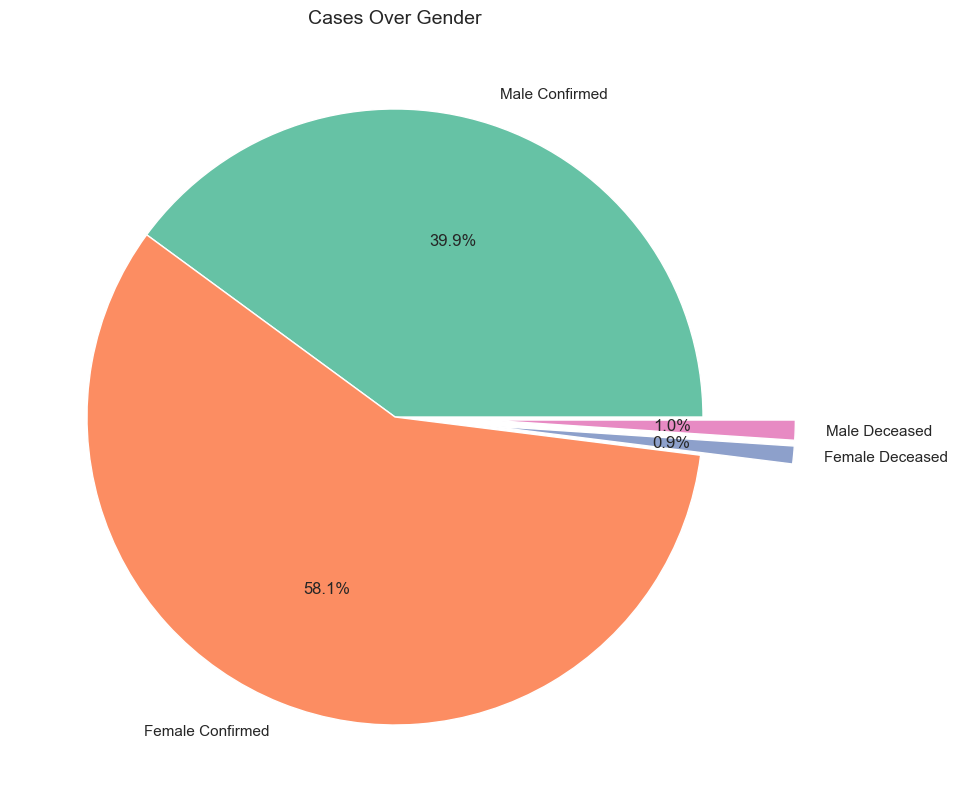

In [45]:
# Set figure size
plt.figure(figsize=(10, 10))

# Pie plot distribution
plt.pie(gender_cases,
        labels=["Male Confirmed", 
                "Female Confirmed", 
                "Female Deceased", 
                "Male Deceased"],
        autopct='%1.1f%%',
        startangle=0, 
        explode=[0, 0, 0.3, 0.3], 
        colors=colors)

# Set up title
plt.title("Cases Over Gender", fontsize=14);

In [46]:
print(f"Confirmed cases of Males: {conf_male}")
print(f"Confirmed cases of Females: {conf_female}")
print(f"Deceased cases of Males: {deceased_male}")
print(f"Deceased cases of Females: {deceased_female}")

Confirmed cases of Males: 513727
Confirmed cases of Females: 747467
Deceased cases of Males: 13484
Deceased cases of Females: 12019


As we can see **female have more confirmed cases over men while men have slightly more often deceased because of Covid-19**. 
Now we're going to reflect it in time period.

In [47]:
def add_lines_to_plot(date, ylimit=0.65):
    """
    Draw text on the line base in custom place on y axis
    :param date: Takes date
    :param ylimit: Takes value in y axis for text 
    :return: Added line with text
    """
    # Add vertical lines
    plt.axvline(x=pd.to_datetime(date), 
                color='r', 
                linestyle='--')

    # Change dtype of string
    date_object = pd.to_datetime(date)

    # Add label for line
    plt.text(date_object,
             plt.ylim()[1] * ylimit,
             f'{date}',
             rotation=90,
             horizontalalignment='right')

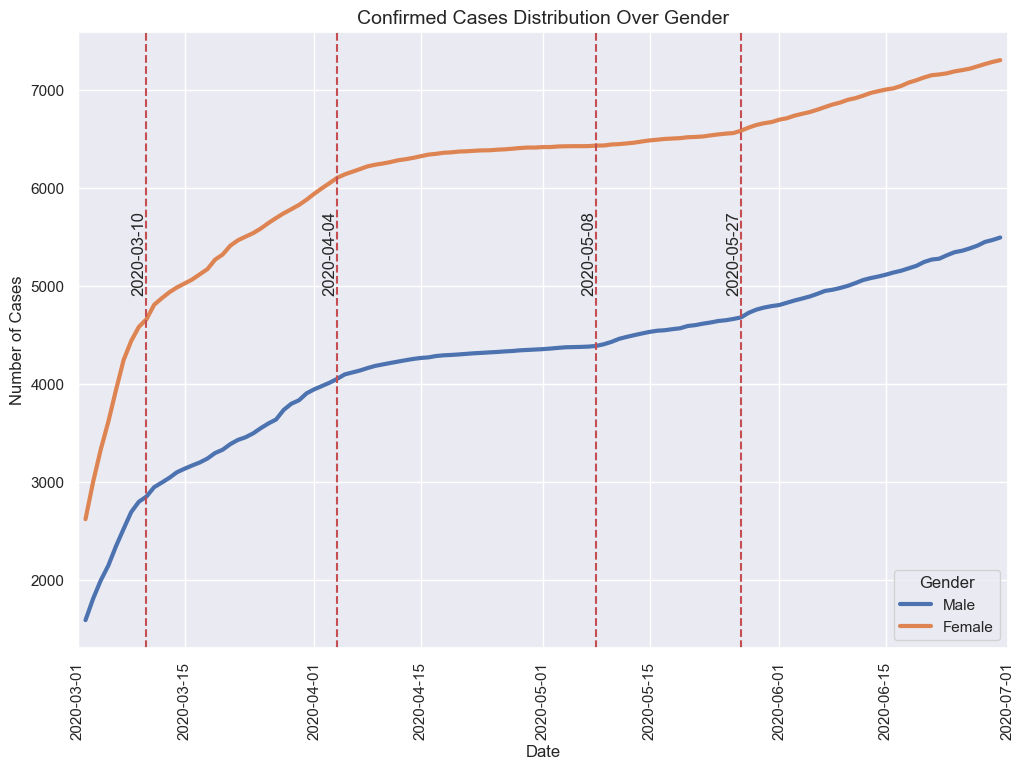

In [48]:
# Plot confirmed cases over gender distribution in the time period.
line_plot(dataframe=df_timegender, x="date", y="confirmed", hue="sex");

# Set up important dates
confirmed_important_dates = [
    "2020-03-10", "2020-04-04", "2020-05-08", "2020-05-27"
]

# Add vertical lines
for date in confirmed_important_dates:
    add_lines_to_plot(date)

As shown before **females tend to get Covid-19 more often than mens** we can see than from the beginning of date both genders spikes till **2020-03-10** than line starts to bend, other line bending can be seen at **2020-04-04** from this date cases start stabilizing. From **2020-05-08 men and 2020-05-07 women start to get more cases again**.

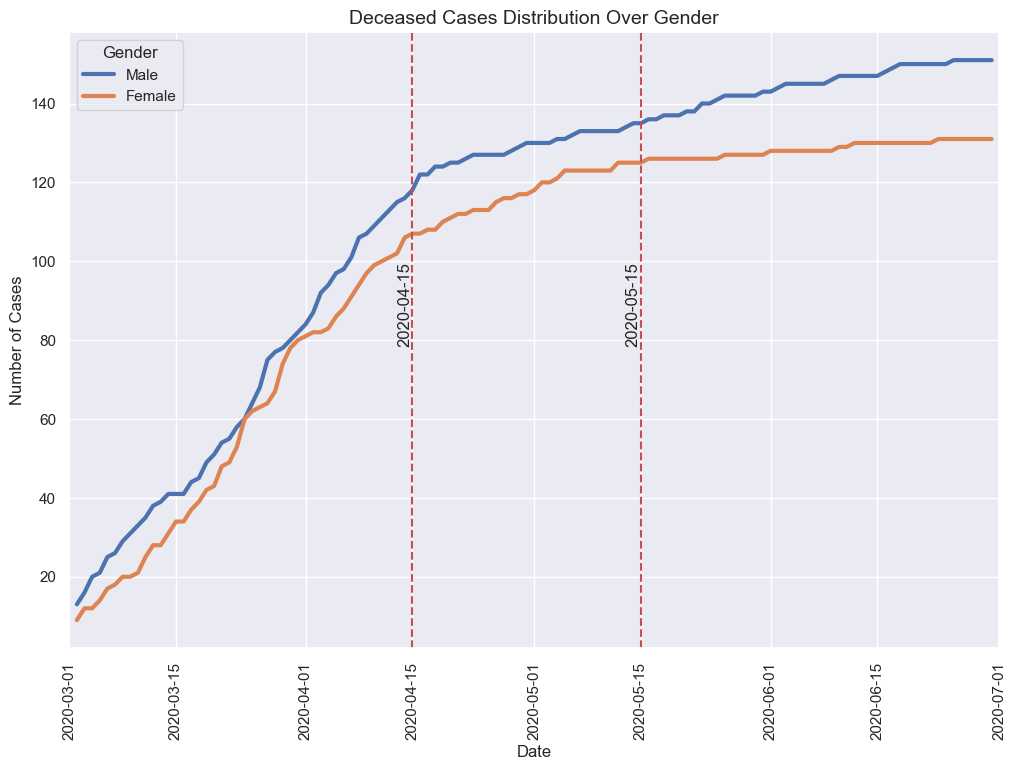

In [49]:
# Plot confirmed cases over gender distribution in the time period.
line_plot(dataframe=df_timegender, x="date", y="deceased", hue="sex");

# Set up important dates
deceased_important_dates = ["2020-04-15", "2020-05-15"]

# Add vertical lines
for date in deceased_important_dates:
    add_lines_to_plot(date, ylimit=0.5)

As reflected both genders have very similar deceased numbers over time at about **2020-04-15 both genders start to stabilize and cases stop growing so rapidly, other date to mention is 2020-05-15 from here female cases have only few case increase while male still increasing**. 

## EDA Time

<ul>
    <li><b>How many people in the South Korea were affected by COVID?</b></li>
</ul>

In [50]:
df_time.describe()

,test,negative,confirmed,released,deceased
count,1.630000e+02,1.630000e+02,163.000000,163.000000,163.000000
mean,4.977797e+05,4.754839e+05,7834.865031,5604.312883,157.104294
std,3.958830e+05,3.865611e+05,4666.040541,4544.317229,114.010916
min,1.000000e+00,0.000000e+00,1.000000,0.000000,0.000000
25%,9.648800e+04,5.877400e+04,3443.000000,29.000000,17.500000
50%,5.030510e+05,4.773030e+05,10450.000000,7117.000000,208.000000
75%,7.825585e+05,7.542225e+05,11116.000000,10100.500000,263.500000
max,1.273766e+06,1.240157e+06,12800.000000,11537.000000,282.000000


We observe similarity in correlation between the variables **test and negative**. Additionally, a similar correlation pattern is identified between **confirmed and released**.  To gain a deeper understanding, let's further investigate and analyze these correlation values.

In [51]:
# Set up list of cases
case_types = df_time.columns

# Set tup min max date values
min_time_date = df_time["date"].min()
max_time_date = df_time["date"].max()

case_types

Index(['date', 'test', 'negative', 'confirmed', 'released', 'deceased'], dtype='object')

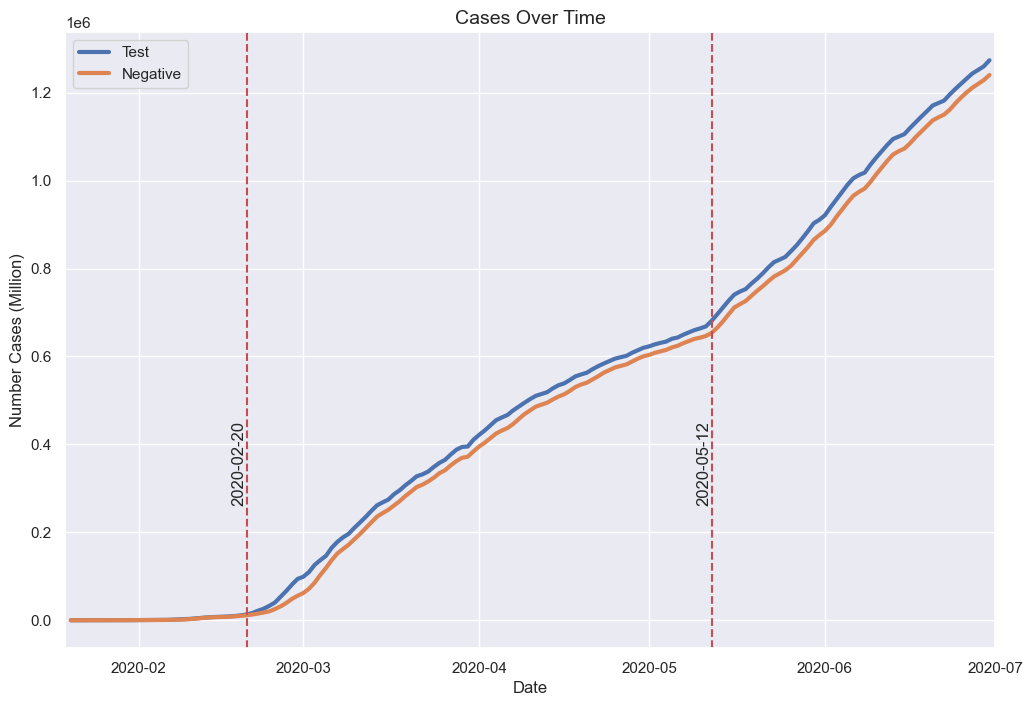

In [52]:
# Plot test cases over negative distribution in the time period.
# Set figure size
plt.figure(figsize=(12, 8))

# Plot line plot
for plot in case_types[1:3]:
    sns.lineplot(data=df_time,
                 x=df_time[case_types[0]],
                 y=df_time[plot],
                 label=plot.title(),
                 linewidth=3)

# Set up important dates
time_important_dates = ["2020-02-20", "2020-05-12"]

# Add vertical lines
for date in time_important_dates:
    add_lines_to_plot(date, ylimit=0.2)

# Set up title and labels
plt.title("Cases Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number Cases (Million)")
plt.xlim(min_time_date - timedelta(days=1), max_time_date + timedelta(days=1));

As reflected two days **2020-02-20 and 2020-05-12** are most important. **First date show when cases start increasing second show vertical increase**. We also can see that **tests are close with negative cases and both of them have linear increase.** Now we are going to check confirmed and released cases over deceased.

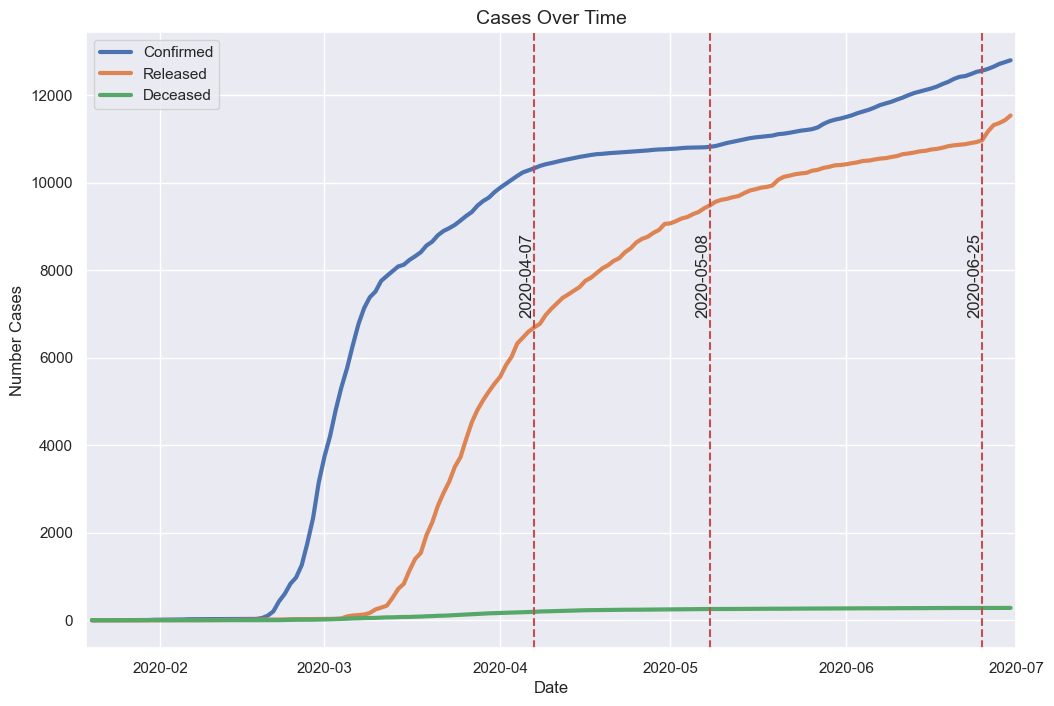

In [53]:
# Plot distribution of test cases over negative in the time period.
# Set figure size
plt.figure(figsize=(12, 8))

# Plot line plot
for plot in case_types[3:]:
    sns.lineplot(data=df_time,
                 x=df_time[case_types[0]],
                 y=df_time[plot],
                 label=plot.title(),
                 linewidth=3)

# Set up importand dates
time_important_dates = ["2020-04-07", "2020-05-08", "2020-06-25"]

# Add vertical lines
for date in time_important_dates:
    add_lines_to_plot(date, ylimit=0.52)

# Set up title and labels
plt.title("Cases Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number Cases")
plt.xlim(min_time_date - timedelta(days=1), max_time_date + timedelta(days=1));

From line chart we see that **confirmed cases start bending horizontally 2020-04-07 but started to increase again from 2020-05-08**. From other hand **released cases increasing stably until 2020-06-05 from there cases start increasing way faster**.

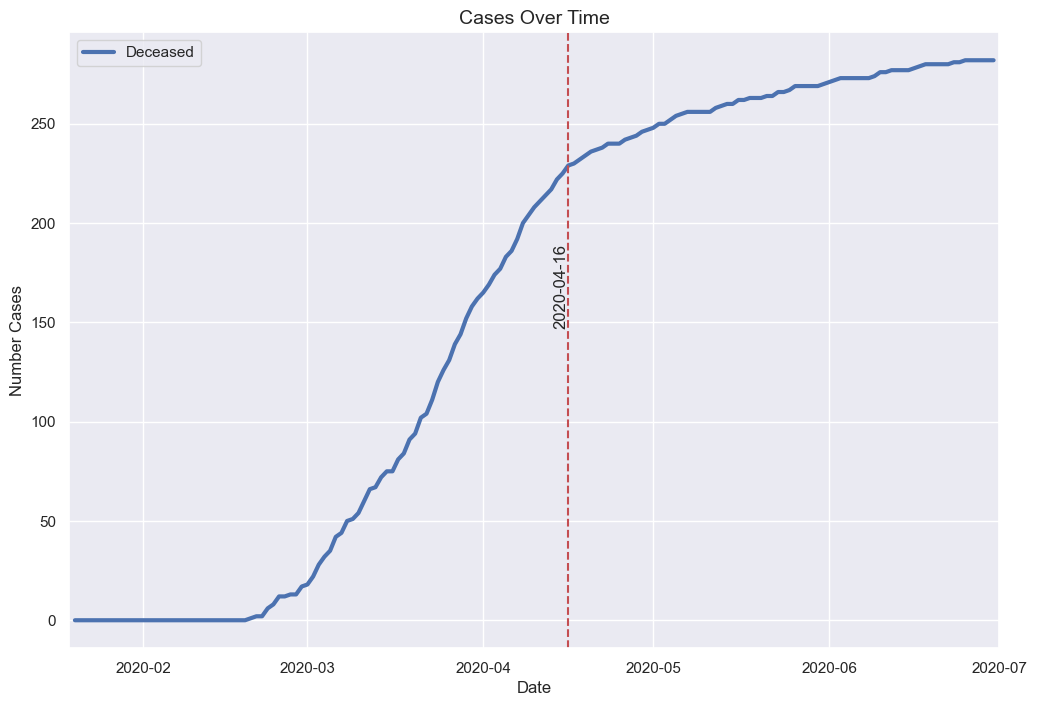

In [54]:
# Plot deceased distribution in the time period.
# Set figure size
plt.figure(figsize=(12, 8))

# Plot line plot
sns.lineplot(data=df_time,
             x="date",
             y="deceased",
             label="Deceased",
             linewidth=3)

# Set up important dates
time_important_dates = ["2020-04-16"]

# Add vertical lines
for date in time_important_dates:
    add_lines_to_plot(date, ylimit=0.5)

# Set up title and labels
plt.title("Cases Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number Cases")
plt.xlim(min_time_date - timedelta(days=1), max_time_date + timedelta(days=1));

For deceased chart we see that at **2020-04-16 deceased number stop increasing so much and try to stabilize**.

## EDA Policy

<ul>
    <li><b>How the goverment deals with COVID?</b></li>
</ul>

In [55]:
# Group data over policy type
df_policy_group_type = df_policy.groupby(
    by=["type"]).size().reset_index(name="count")

# Sort data
df_policy_group_type.sort_values(
    by=["count"], 
    ascending=False, 
    inplace=True)

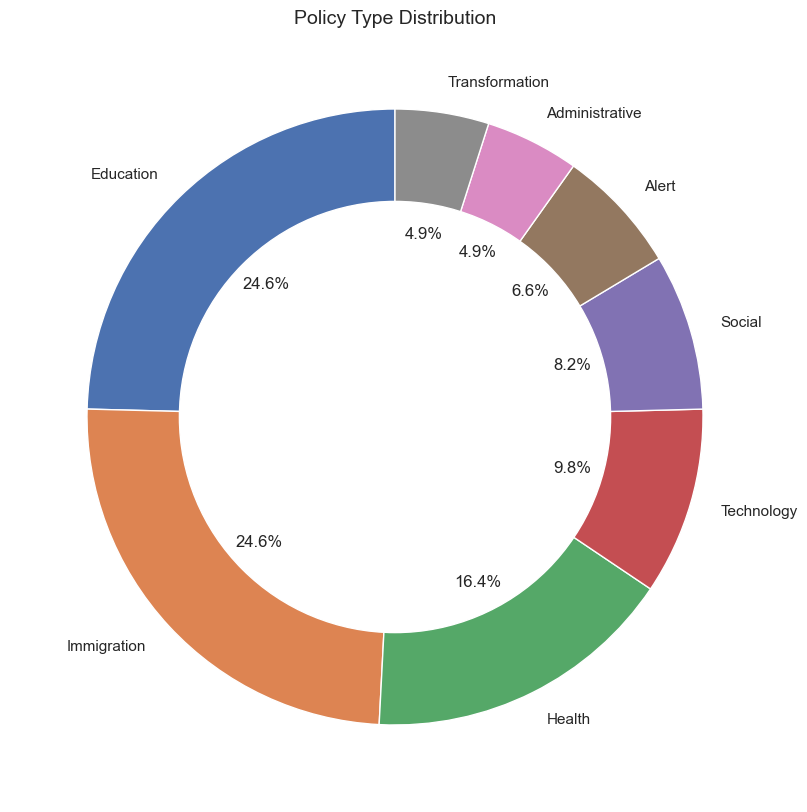

In [56]:
# Set figure size
plt.figure(figsize=(10, 10))

# Set up labels
policy_type_labels = [x for x in df_policy_group_type["type"]]

# Pie plot distribution
plt.pie(df_policy_group_type["count"],
        autopct='%1.1f%%',
        labels=policy_type_labels,
        startangle=90)

# Set up white circle in the middle to get donut
circle_center = plt.Circle((0, 0), 
                           0.7, 
                           color="white")

# Remove middle of pie
plt.gca().add_artist(circle_center)

# Set title
plt.title("Policy Type Distribution", fontsize=14);

In [57]:
# Rotate data frame
df_policy_group_type.transpose()

,2,4,3,6,5,1,0,7
type,Education,Immigration,Health,Technology,Social,Alert,Administrative,Transformation
count,15,15,10,6,5,4,3,3


As we see most popular 3 policy types are **Education takes 24.6% of all dataset - 15 government policies, Immigration 24.6% - 15 government policies and Health 16.4% with 10 policies**. We can also check how policy distributes in different months.

In [58]:
# Create two columns one for number or month second for month name
df_policy["start_month"] = df_policy['start_date'].dt.month
df_policy["month_name"] = df_policy['start_date'].dt.strftime('%B')

# Get count for each group
df_policy_edited = df_policy.groupby(
    by=["start_month", "month_name"]).size().reset_index(name='count')

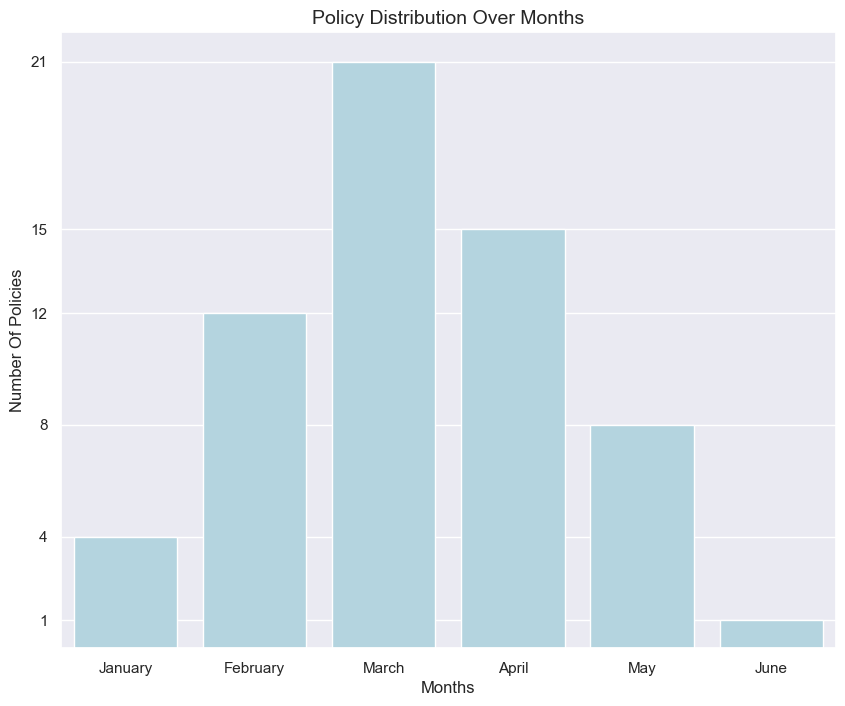

In [59]:
# Set figure size
plt.figure(figsize=(10, 8))

# Plot bar plot
sns.barplot(data=df_policy_edited,
            x="month_name",
            y="count",
            color="lightblue")

# Set title and labels
plt.title("Policy Distribution Over Months", fontsize=14)
plt.xlabel("Months")
plt.ylabel("Number Of Policies")

# Show only important ticks
plt.yticks(ticks=df_policy_edited["count"]);

From chart, we see that in **March there was most of the policies - 21, as we know in this month the growth of cases groth rate was the biggest**. Let's see what government policy was declared overall. We will set the **threshold to 1, so we will put all policies to "Others" if they appear only once**, otherwise we will show them.

In [60]:
# Group by policy
df_policy_group_policy = df_policy.groupby(
    by=["gov_policy"]).size().reset_index(name="count")

# Threshold for other cases
threshold = 1

# Create a new column for labels based on the count, set axis 1 to check rows
df_policy_group_policy['label'] = df_policy_group_policy.apply(
    lambda row: row['gov_policy'].title()
    if row['count'] > threshold else 'Others',
    axis=1)

# Join data for the "Others" category
df_policy_pie = df_policy_group_policy.groupby(
    by=['label'])['count'].sum().reset_index()

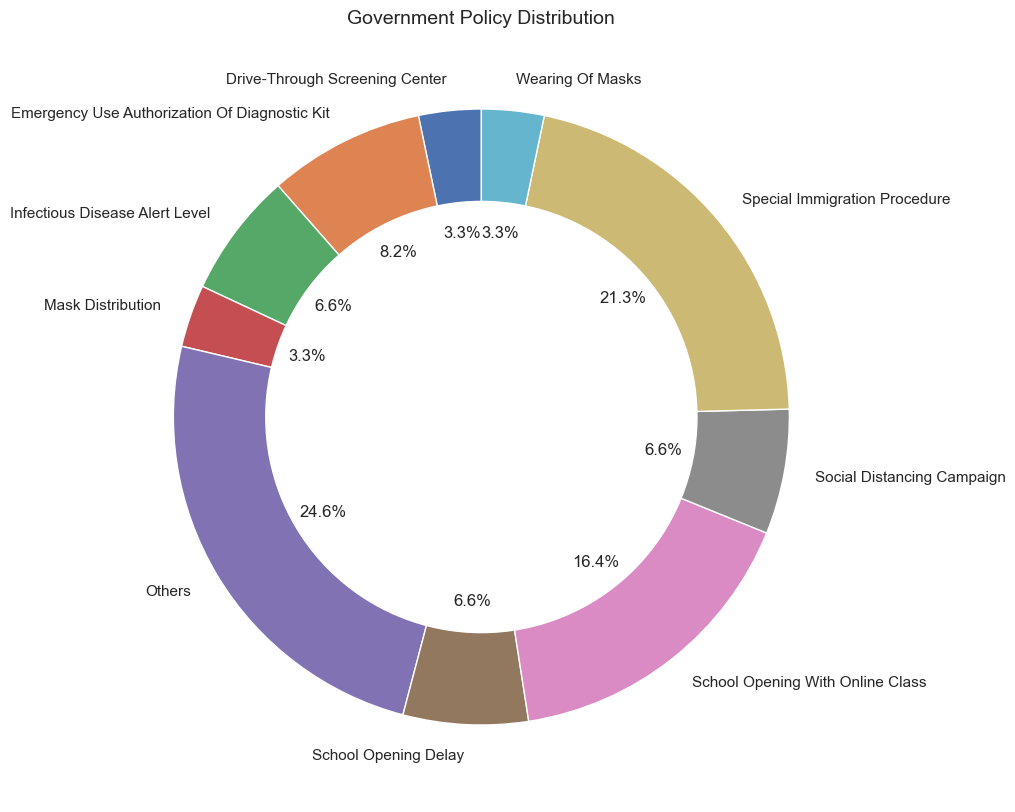

In [61]:
# Set figure size
plt.figure(figsize=(10, 10))

# Pie plot distribution
plt.pie(data=df_policy_pie,
        x="count",
        autopct='%1.1f%%',
        labels="label",
        startangle=90)

# Set up white circle in the middle to get donut
circle_center = plt.Circle((0, 0), 
                           0.7, 
                           color="white")

# Remove middle of pie
plt.gca().add_artist(circle_center)

# Set title
plt.title("Government Policy Distribution", fontsize=14);

In [62]:
# Sort types by count
df_policy_pie = df_policy_pie.sort_values(by=["count"], 
                                          ascending=False)

# Get all policies excluding individuals
top_gov_policies = df_policy_pie[df_policy_pie["label"] != "Others"]
top_gov_policies.head()

,label,count
8,Special Immigration Procedure,13
6,School Opening With Online Class,10
1,Emergency Use Authorization Of Diagnostic Kit,5
2,Infectious Disease Alert Level,4
5,School Opening Delay,4


As shown **Special Immigration Procedure and School Opening With Online Class** policies used most often, basically country stop immigration to prevent new cases from other country's and also started online classes, so most of the youngest people stop spreading virus. Now we proceed further and see how most often declared government policy impact cases.

In [63]:
# Get only needed type policy
df_policy_alert = df_policy[
    ~df_policy["start_date"].where(
        df_policy["type"] == "Alert").isna()]

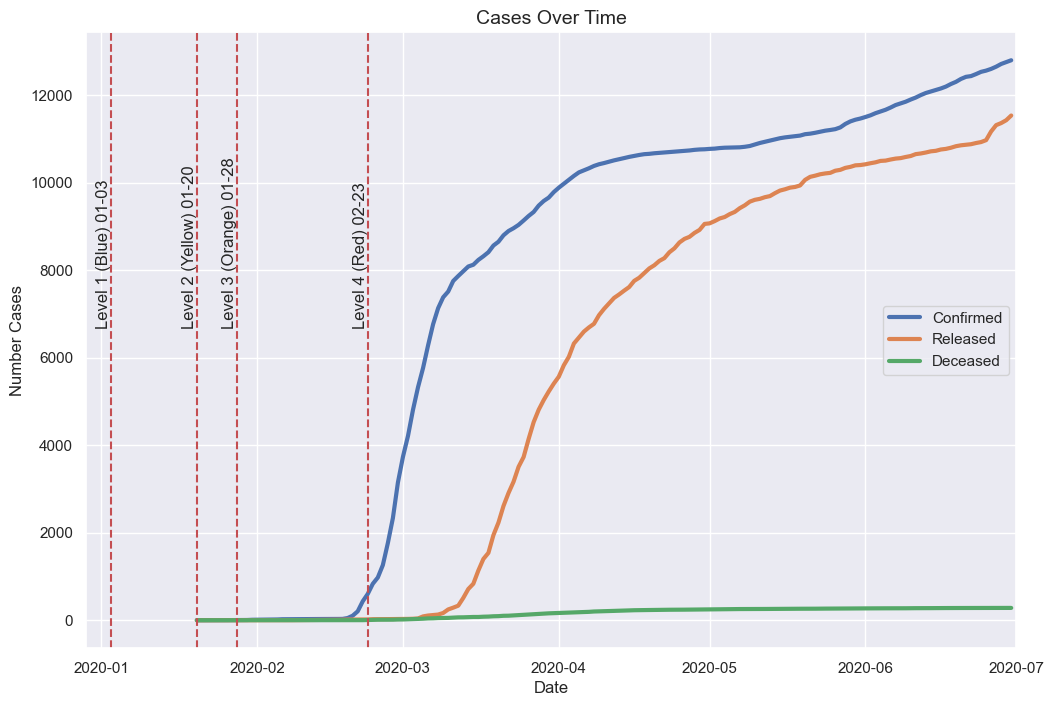

In [64]:
# Plot policies with confirmed cases 
# Set figure size
plt.figure(figsize=(12, 8))

# Plot line plot
for plot in case_types[3:]:
    sns.lineplot(data=df_time, 
                 x=df_time[case_types[0]], 
                 y=df_time[plot], 
                 label=plot.title(),
                 linewidth=3)

# Add detailed vertical lines
for index, row in df_policy_alert.iterrows():
    
    # Set variables
    date = row["start_date"]
    detail = row["detail"]
    
    # Add line
    plt.axvline(x=date, 
                color="r", 
                linestyle="--")
    
    # Format the date
    formatted_date = date.strftime("%m-%d")
    
    # Add label for line
    plt.text(date, 
             plt.ylim()[1]*0.5, 
             f'{detail} {formatted_date}', 
             rotation=90, 
             horizontalalignment='right')

plt.title("Cases Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number Cases")
plt.xlim(df_policy_alert["start_date"].min() - timedelta(days=5), max_time_date + timedelta(days=1));

In [65]:
df_policy_alert.style.hide(axis="index")

type,gov_policy,detail,start_date,start_month,month_name
Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03 00:00:00,1,January
Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20 00:00:00,1,January
Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28 00:00:00,1,January
Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23 00:00:00,2,February


<ul>
    <li>We may see that Infectious Disease Alert was already started before first cases. </li>
    <li>Alert Level 1 (Blue) was initiated 01-03. </li> 
    <li>Level 2 (Yellow) right when first confirmed case was registered </li> 
    <li>Level 3 (Orange) when 100 test was made </li>
    <li>Level 4 (Red) when confirmed cases started to spike.</li>
</ul>

In [66]:
# Get only needed type policy
df_policy_immigration = df_policy[
    ~df_policy["start_date"].where(
        df_policy["type"] == "Immigration").isna()]

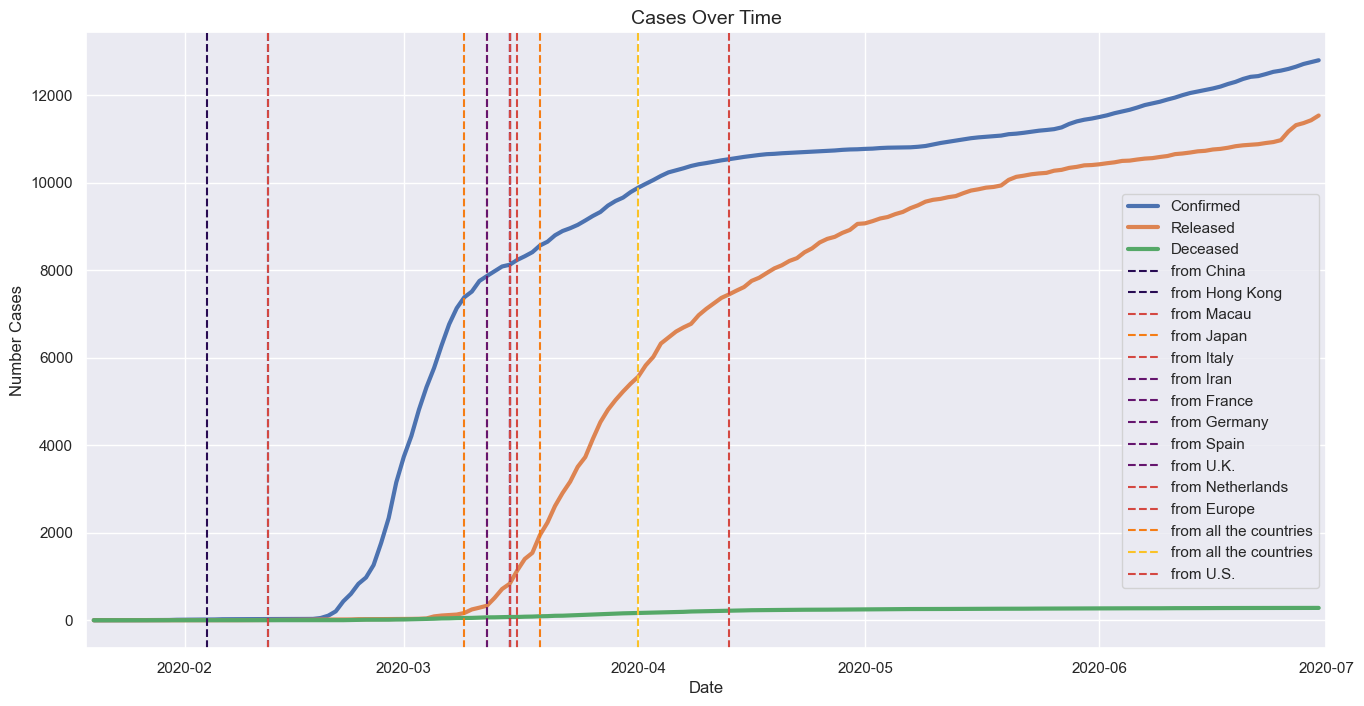

In [67]:
# Plot policies with confirmed cases 
# Set figure size
plt.figure(figsize=(16, 8))

# Plot line plot
for plot in case_types[3:]:
    sns.lineplot(data=df_time, 
                 x=df_time[case_types[0]], 
                 y=df_time[plot], 
                 label=plot.title(),
                 linewidth=3)

# Add detailed vertical lines
for index, row in df_policy_immigration.iterrows():
    
    # Set variables
    date = row["start_date"]
    detail = row["detail"]
    random_color = random.choice(sns.color_palette("inferno"))
    
    # Add line
    plt.axvline(x=date, 
                color=random_color, 
                linestyle="--", 
                label=f"{detail}")

plt.title("Cases Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number Cases");
plt.legend(bbox_to_anchor=(1.0, 0.75), loc='upper right')
plt.xlim(min_time_date - timedelta(days=1), max_time_date + timedelta(days=1));

In [68]:
df_policy_immigration.style.hide(axis="index")

type,gov_policy,detail,start_date,start_month,month_name
Immigration,Special Immigration Procedure,from China,2020-02-04 00:00:00,2,February
Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12 00:00:00,2,February
Immigration,Special Immigration Procedure,from Macau,2020-02-12 00:00:00,2,February
Immigration,Special Immigration Procedure,from Japan,2020-03-09 00:00:00,3,March
Immigration,Special Immigration Procedure,from Italy,2020-03-12 00:00:00,3,March
Immigration,Special Immigration Procedure,from Iran,2020-03-12 00:00:00,3,March
Immigration,Special Immigration Procedure,from France,2020-03-15 00:00:00,3,March
Immigration,Special Immigration Procedure,from Germany,2020-03-15 00:00:00,3,March
Immigration,Special Immigration Procedure,from Spain,2020-03-15 00:00:00,3,March
Immigration,Special Immigration Procedure,from U.K.,2020-03-15 00:00:00,3,March


<ul>
    <li>Immigration procedure was started February 4 after Level 3 alert, first ones was made for China, Hong Kong and Macau, then from March 9 when confirmed cases started to stabilize and release cases started to rise until March 19 all countries was added to this procedure. </li>
    <li>At April 1 Mondatory 14-day Self-Quarantine policy initiated for all countries and at March 13 Self-Quarantine and Diagnostic Tests was initiated for U.S.</li>
</ul>

In [69]:
# Get only needed type
df_policy_health = df_policy[
    ~df_policy["start_date"].where(
        df_policy["type"] == "Health").isna()].sort_values(
    by=["start_date", 
        "gov_policy"])

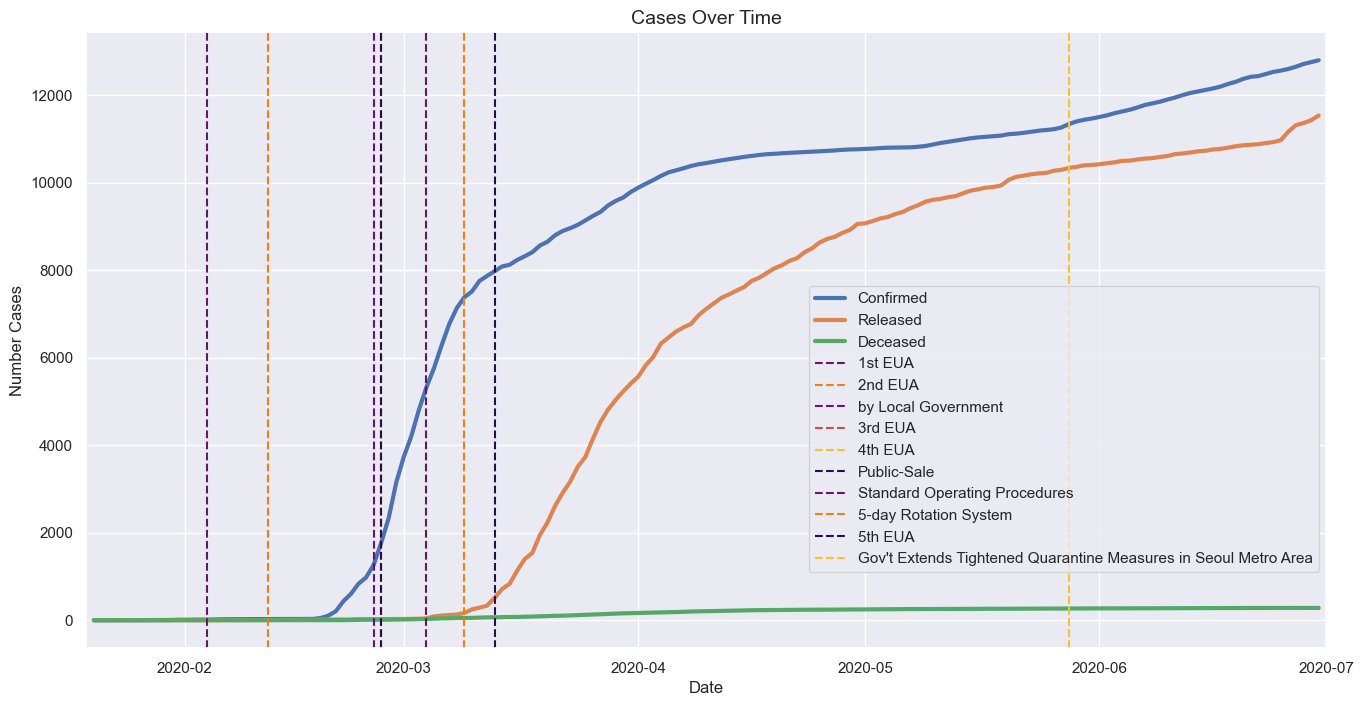

In [70]:
# Plot policies with confirmed cases 
# Set figure size
plt.figure(figsize=(16, 8))

# Plot line plot
for plot in case_types[3:]:
    sns.lineplot(data=df_time, 
                 x=df_time[case_types[0]], 
                 y=df_time[plot], 
                 label=plot.title(),
                 linewidth=3)

    
# Add detailed vertical lines
for index, row in df_policy_health.iterrows():
    
    # Set variables
    date = row["start_date"]
    detail = row["detail"]
    random_color = random.choice(sns.color_palette("inferno"))
    
    # Add line
    plt.axvline(x=date, 
                color=random_color, 
                linestyle="--", 
                label=f"{detail}")

plt.title("Cases Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number Cases")

# Add a custom legend with the Line2D objects
plt.legend(bbox_to_anchor=(1.0, 0.6), loc='upper right')
plt.xlim(min_time_date - timedelta(days=1), max_time_date + timedelta(days=1));

In [71]:
df_policy_health.style.hide(axis="index")

type,gov_policy,detail,start_date,start_month,month_name
Health,Emergency Use Authorization of Diagnostic Kit,1st EUA,2020-02-04 00:00:00,2,February
Health,Emergency Use Authorization of Diagnostic Kit,2nd EUA,2020-02-12 00:00:00,2,February
Health,Drive-Through Screening Center,by Local Government,2020-02-26 00:00:00,2,February
Health,Emergency Use Authorization of Diagnostic Kit,3rd EUA,2020-02-27 00:00:00,2,February
Health,Emergency Use Authorization of Diagnostic Kit,4th EUA,2020-02-27 00:00:00,2,February
Health,Mask Distribution,Public-Sale,2020-02-27 00:00:00,2,February
Health,Drive-Through Screening Center,Standard Operating Procedures,2020-03-04 00:00:00,3,March
Health,Mask Distribution,5-day Rotation System,2020-03-09 00:00:00,3,March
Health,Emergency Use Authorization of Diagnostic Kit,5th EUA,2020-03-13 00:00:00,3,March
Health,Extends Tightened Quarantine Measures,Gov't Extends Tightened Quarantine Measures in Seoul Metro Area,2020-05-28 00:00:00,5,May


<ul>
    <li>For Health policy on February 4 Emergency Use Authorization (EUA) was granted - it is special permission allowing the use of a diagnostic test before approval process. This policy often granted quickly to respond for health crises. Over all time 5 (EUA) was granted overall. </li>
    <li>Also on February 26 Drive-Through Screening Center was established to more quickly and efficiently check cases by Local Governments but on March 4 it was Standard Operating Procedure overall. </li>
    <li>At February 27 3th and 4th EUA Mask Distribution policy granted right besides Mask Distribution. </li>
    <li>Other Mask Distribution is 5-day Rotation System which was established on March 9 to stabilize mask and medical supply distribution. </li>
    <li>Lastly on May 28 Government extends tightened quarantine measures in South Korea capital Seoul in Metro area. </li>
</ul>

## EDA Region And Time Province

<ul>
    <li><b>Does education level have any inpact to virus?</b></li>
</ul>

In [72]:
# Select only custom rows
region_custom = df_region[df_region["province"] == df_region["city"]]

# Drop columns
region_grouped = region_custom.drop(
    columns=["code", "city", "latitude", "longitude"])

# Group by province
timeprovince_grouped = df_timeprovince.groupby(by=["province"])[[
    "confirmed", "released", "deceased"
]].sum()

# Merge province with regions
region_province = timeprovince_grouped.merge(region_grouped,
                                             how="left",
                                             on="province")

# Create correlation matrix
region_province_corr = region_province.iloc[:, 1:].corr()

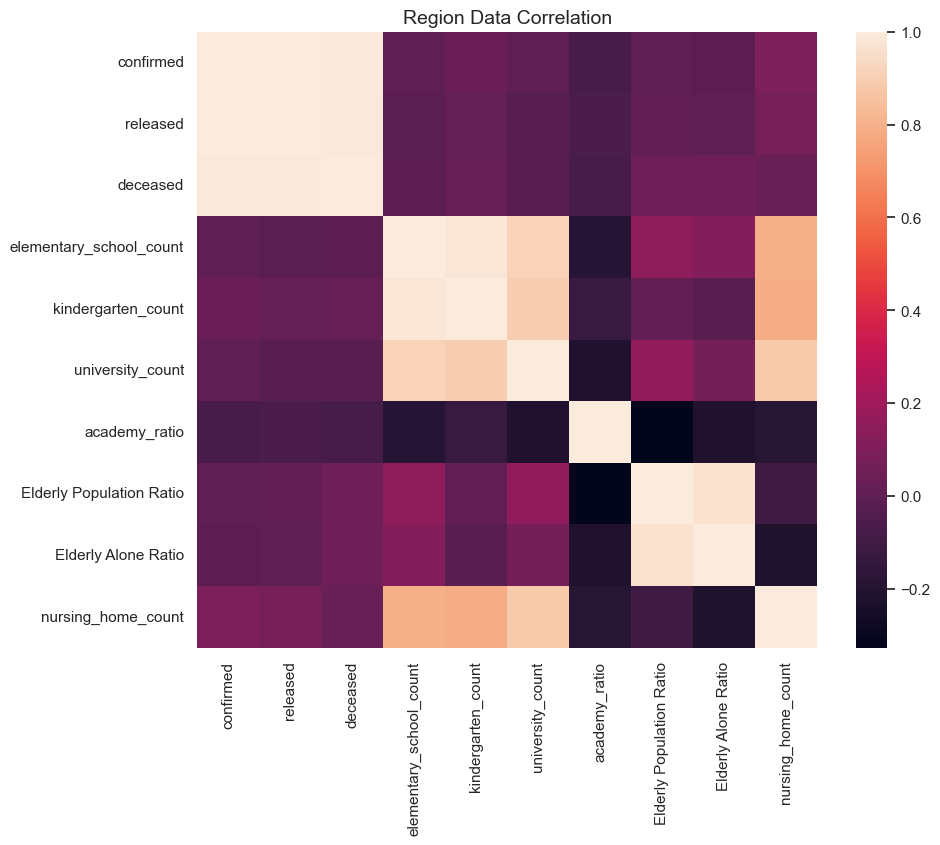

In [73]:
# Plot correlation matrix. 
# Set figure size
plt.figure(figsize=(10, 8))

# Plot line plot
sns.heatmap(region_province_corr, 
            annot=False, 
            fmt=".2f")

plt.title("Region Data Correlation", fontsize=14);

As detailed Covid-19 cases have almost 0 correlation to education, we could think that people who are more educated tend to look after them self more, wash hands more often, wear masks etc. But from plot we see that virus break through so fast and efficient that nobody was preparing and didn't know how to fight with the virus. Besides a virus we see strong correlation between **elementary schools, kinder garden, university and nursing homes** the more educated people the more place to get education they need, also the health need increase. Also, we see positive correlation with **elderly being alone with population ratio** which is obvious that older individuals is more likely to live alone. One more thing we can see is elderly ratio over the region and negative academy ratio over other education places, the ratio decrease the more education places exists, people tend to pick academy over other places.

Let's see how educational institutions distributes over South Korea.

In [74]:
# Data frame with city-province averages
df_region_province = df_region[
    df_region["province"] == df_region["city"]]

# Data frame without city-province averages
df_region_province_excluded = df_region[
    ~df_region.duplicated(
        subset=["province", "city"], 
        keep=False)]

In [75]:
# Load SK to notebook
south_korea_gdf = gpd.read_file(south_korea_shp_path)

# Get the bounding box of South Korea
minx = df_region_province_excluded["longitude"].min() - 1
miny = df_region_province_excluded["latitude"].min() - 1
maxx = df_region_province_excluded["longitude"].max() + 1
maxy = df_region_province_excluded["latitude"].max() + 1

In [76]:
# Plot scatterplot on the map
def plot_scatter_map(dataframe, long, lat, hue=None, size=None):
    """
    Plot scatter plot on the South Korea map
    :param dataframe: Dataframe
    :param long: Longitude column name
    :param lat: Latitude column name
    :param hue: Hue column name
    :param size: Size column name
    :return: 
    """
    # Plot academy distribution over SK
    # Set figure size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot SK shape
    south_korea_gdf.plot(ax=ax, color="lightblue", edgecolor="black")

    # Plot scatter plot
    sns.scatterplot(data=dataframe, 
                    x=long, 
                    y=lat, 
                    hue=hue, 
                    size=size, 
                    sizes=(50, 200), 
                    alpha=0.7)

    # Add main cities add markers 
    for index, row in df_region_province.iterrows():

        # Add city markers
        plt.scatter(row["longitude"], 
                    row["latitude"], 
                    marker='x', 
                    color='red')
    
    # Set the limits of the plot to focus on South Korea
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Set up title, labels and legend
    plt.title("Academy Distribution Over South Korea", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

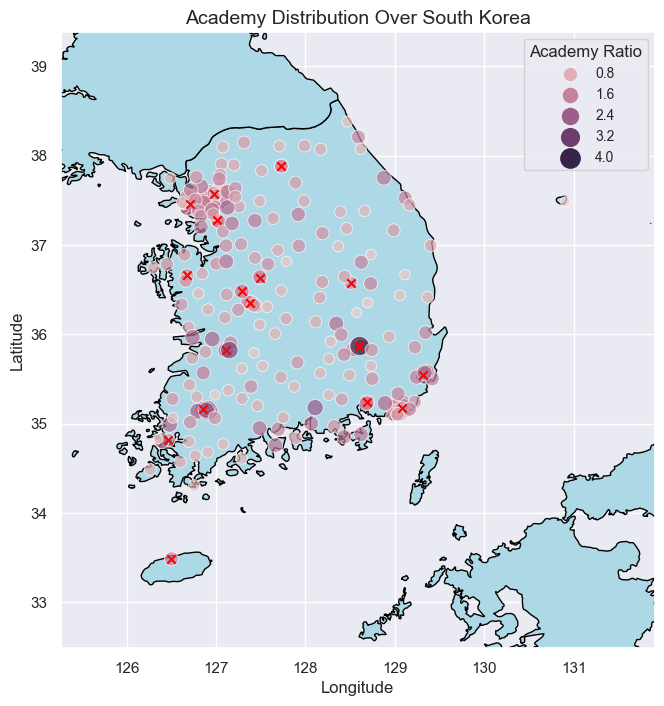

In [77]:
# Plot academy distribution over SK
plot_scatter_map(dataframe=df_region_province_excluded, 
                 long="longitude", 
                 lat="latitude", 
                 hue="academy_ratio", 
                 size="academy_ratio")
plt.title("Academy Distribution Over South Korea", fontsize=14)
plt.legend(title="Academy Ratio", fontsize="small");

We see that academies scatter across all South Korea, but most of them situated near the Special City / Metropolitan City / Province marked with red cross. People tend to pick Academy over other institution because it's cheaper and easier to get a place in it.

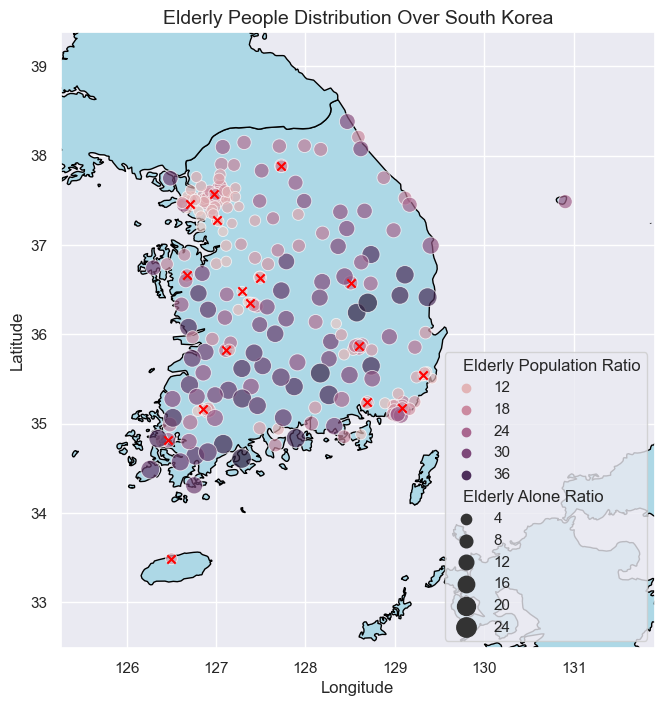

In [78]:
# Plot elderly population over alone ratio distribution over country
plot_scatter_map(dataframe=df_region_province_excluded, 
                 long="longitude", 
                 lat="latitude", 
                 hue="Elderly Population Ratio", 
                 size="Elderly Alone Ratio")
plt.title("Elderly People Distribution Over South Korea", fontsize=14);

As we see most elderly people live in South - South West of contry, base by population and alone ratio they live is less populated zones. Meanwhile, younger people lives near bigger cities and capital. Special City / Metropolitan City / Province marked with red cross.

## Hierarchical Clustering

Before visualizing data in single scatter plot we need to prepare it. First we need to find optimal cluster size. As we know there is no optimal way of finding the right number of clusters, so we will get some additional help by using dendrogram.

In [79]:
# Calculate difference between test values
df_time["increase_test"] = df_time["test"].diff()

# Calculate difference between confirmed values
df_time["increase_confirmed"] = df_time["confirmed"].diff()

# Replace NaN with 0
df_time[["increase_test", "increase_confirmed"]] = df_time[["increase_test", "increase_confirmed"]].fillna(0)

In [80]:
# Preparing dataset
clust_test_confirmed = df_time[["increase_test", "increase_confirmed"]].values

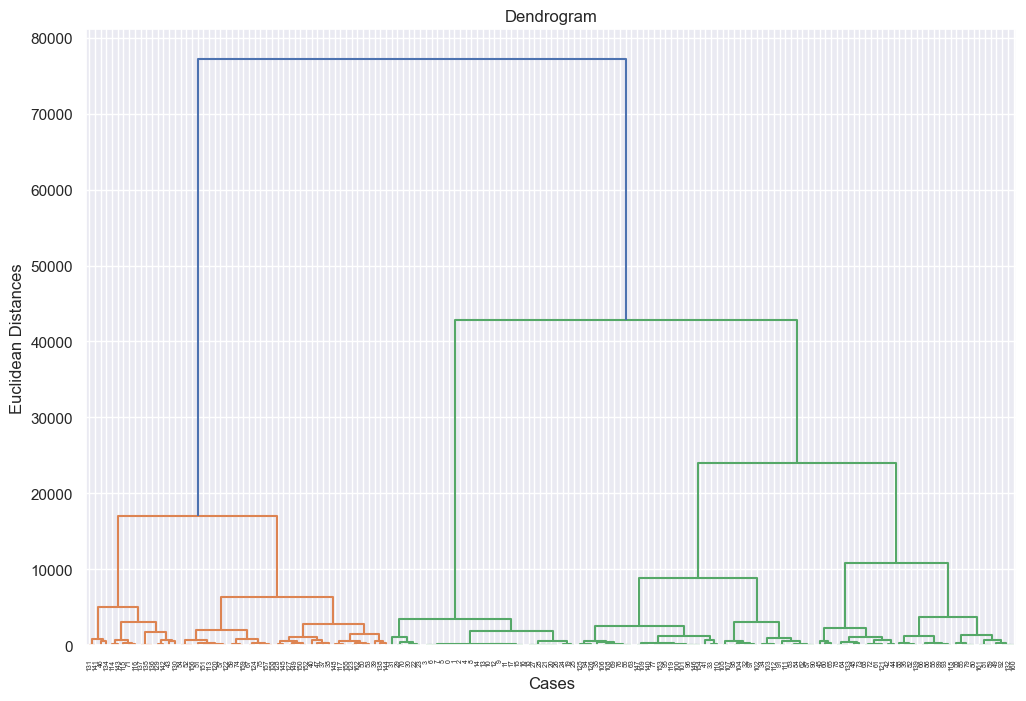

In [81]:
# Set figure size
plt.figure(figsize=(12, 8))

# Using the dendrogram to find the optimal number of clusters
dendogram = sch.dendrogram(sch.linkage(clust_test_confirmed, method="ward"))

# Set up title and labels
plt.title("Dendrogram")
plt.xlabel("Cases")
plt.ylabel("Euclidean Distances");

As we see optimal cluster size is 5, now we can train the Hierarchical Clustering model on the dataset.

In [82]:
from sklearn.cluster import AgglomerativeClustering

# Training the model
number_of_cluster = 5
hc = AgglomerativeClustering(n_clusters=number_of_cluster, affinity="euclidean", linkage="ward")
hc_fited = hc.fit_predict(clust_test_confirmed)

E:\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


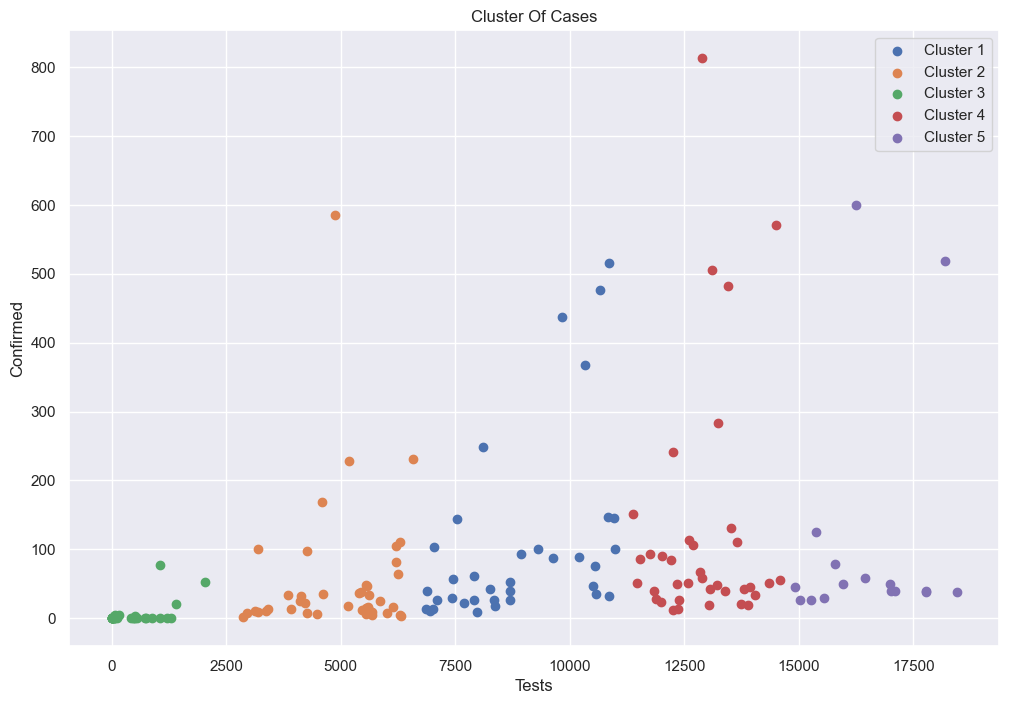

In [83]:
# Set figure size
plt.figure(figsize=(12, 8))

# Plot clusters
for i in range(number_of_cluster):
    plt.scatter(clust_test_confirmed[hc_fited == i, 0], 
                clust_test_confirmed[hc_fited == i, 1], 
                label=f"Cluster {i + 1}")

# Set tup title, labels and legent
plt.title("Cluster Of Cases")
plt.xlabel("Tests")
plt.ylabel("Confirmed")
plt.legend();

From scatter plot we see 5 clusters, this suggests that virus could spread in different ways over South Korea. Also more people are being tested which show increasing confirmed cases being detected so virus is spreading more quickly infecting more and more. 

## Random Forest Classification

In [84]:
# Importing additional libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [85]:
# Preparing dataset
knn_dataset = df_timeage[["age", 
                          "confirmed", 
                          "deceased"]]
knn_dataset.loc[:, "age"] = knn_dataset["age"].apply(
    lambda x: 
    int(x.replace("s", "")))

C:\Users\wwric\AppData\Local\Temp\ipykernel_15644\3834931568.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_dataset.loc[:, "age"] = knn_dataset["age"].apply(


In [86]:
# Selecting features
x = knn_dataset.iloc[:, :-1].values
y = knn_dataset.iloc[:, -1].values

In [87]:
# Splitting the dataset into the Training seet and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.25, 
                                                    random_state=0)

# Feature Scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Training the Random Forest Classification model on the Training set
classifier = RandomForestClassifier(n_estimators=10, 
                                    criterion="entropy", 
                                    random_state=0)
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [88]:
# Predict deceased numbers base by age and confirmed cases
pred_age = 80
pred_confirmed = 480
classifier.predict(sc.transform([[pred_age, pred_confirmed]]))[0]

110

In [89]:
# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Checking the accuracy
round(accuracy_score(y_test, y_pred), 3)

0.824

# Summary

<ol>
    <li>First person who get Covid-19 was 50s man who got confirmation of virus in 2020-01-23</li>
    <li>Most of the people got infected by contacting with patients and in meeting places.</li>
    <li>Most often, a person comes into contact with 3 other persons, but the number can rise to 8, less to 20 or 30.</li>
    <li>Female tend to contact more from 10s to 30s while men from 40s to 60s, at 100s we don't see contacts at all.</li>
    <li>Group infection takes 68.9% of our data leaving 31.1% to individual one to one contact.</li></li>
    <li>In Confirmed Cases:
        <ul>
            <li>20s take 27% of all cases.</li>
            <li>while 0s take about 1%.</li>
            <li>80s - 4%.</li>
        </ul>
    </li>
<li>In Deceased cases:
    <ul>
        <li>0s, 10s and 20s takes 0%.</li>
        <li>30s, 40s and 50s takes less than 10%.</li>
        <li>60s and 70s takes about 45%.</li>
        <li>80s takes almost 48%.</li>
    </ul>
<li>Virus way danger to older people than younger.</li>
<li>Female takes about ~60% of all cases.</li>
<li>2020-02-20 and 2020-05-12 both dates show high vertical increase over cases.</li>
<li>Confirmed cases start bending horizontally 2020-04-07 but started to increase again from 2020-05-08.</li>
<li>Released cases increasing stably until 2020-06-05 from there cases start increasing way faster.</li>
<li>2020-04-16 deceased number stop increasing so much and try to stabilize.</li>
<li>Education takes 24.6% of all dataset - 15 government policies, Immigration 24.6% - 15 government policies and Health 16.4% with 10 policies.</li>
<li>In March there was most of the policies - 21.</li>
<li>Special Immigration Procedure and School Opening With Online Class policies used most often.</li>
<li>
    <ul>
        <li>Infectious Disease Alert was already started before first cases.</li>
        <li>Alert Level 1 (Blue) was initiated 01-03.</li>
        <li>Level 2 (Yellow) right when first confirmed case was registered.</li>
        <li>Level 3 (Orange) when 100 test was made.</li>
        <li>Level 4 (Red) when confirmed cases started to spike.</li>
    </ul>
</li>
<li>
    <ul>
        <li>Immigration procedure was started February 4 after Level 3 alert, first ones was made for China, Hong Kong and Macau, then from March 9 when confirmed cases started to stabilize and release cases started to rise until March 19 all countries was added to this procedure.</li>
        <li>At April 1 Mondatory 14-day Self-Quarantine policy initiated for all countries and at March 13 Self-Quarantine and Diagnostic Tests was initiated for U.S.</li>
    </ul>
</li>
<li>
    <ul>
        <li>For Health policy on February 4 Emergency Use Authorization (EUA) was granted - it is special permission allowing the use of a diagnostic test before approval process. This policy often granted quickly to respond for health crises. Over all time 5 (EUA) was granted overall.</li>
        <li>Also on February 26 Drive-Through Screening Center was established to more quickly and efficiently check cases by Local Governments but on March 4 it was Standard Operating Procedure overall.</li>
        <li>At February 27 3th and 4th EUA Mask Distribution policy granted right besides Mask Distribution.</li>
        <li>Other Mask Distribution is 5-day Rotation System which was established on March 9 to stabilize mask and medical supply distribution.</li>
        <li>Lastly on May 28 Government extends tightened quarantine measures in South Korea capital Seoul in Metro area.</li>
    </ul>
</li>
<li>People who are more educated generally have better health habits, like washing hands and wearing masks. It might be expected that they get sick less often, but this isn't always the case.</li>
<li>Places where elderly ratio higher have bigger elderly alone ratio.</li>
<li>We see that academies scatter across all South Korea, but most of them situated near the Special City / Metropolitan City / Province.</li>
<li>Most of older people live in South - South West of country. Meanwhile, younger people lives near bigger cities and capitals.</li>
</ol>

For the plan of stooping the virus we have some key aspects. 

* First of all we know that based by dataset most of the confirmed cases are based on young people, who spend time on school, university, gyms where the most group contacts appeared. Mostly one patient can contact from 0 to 3 peoples and number can rise to 8, sometimes to 20 or 30, so if one person got infected, while traveling from home to school he already can contact a lot of people. So first idea of stooping the virus would be gathering place close procedure, for example opening online classes could stop the spreading. Group gathering should be stop to, for example churches or gyms, where people tend to go from different city zones, this way virus would be stopped from spreading over different city regions. 

* Another aspect we see that older people tend to get deceased more often than younger, we already know that younger people are more active, travel more than older, so young people gathering, traveling would decrease chance to infect others especially older people. We know that most of younger people live near the biggest cities, so all procedures need to be started in those cities. 

* Based by government policy best way to improve situation is to close immigration from other countries while the situation in main country is not controlled, make self isolation for people who got infected or have contact with infected. Also provide mask and medicine over people, so they can start testing them self and start healing.